# Record the locomotion process with various waveform configuration

In [ ]:
### here the locomotion trajectory and sensor signals are recorded
### Waveform: 1) square; 2) sin; 3) saw1; 4) saw2; 5) saw3;
### Stride duration and pressure can be varied;

In [15]:
# libs for Arduino board, live plot
import serial
import pandas as pda
import csv
from itertools import count
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2Tk
from matplotlib.animation import FuncAnimation
# libs for camera display
import cv2
import PIL.Image, PIL.ImageTk
import time
# libs for GUI window
import tkinter

port = serial.Serial('COM3',9600, timeout = 1)

30.0


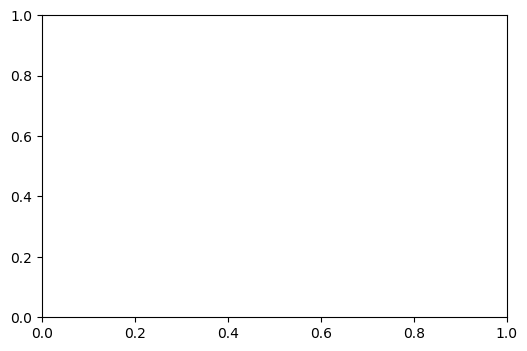

In [17]:
# some programs are deleted, in order to save time to match the main frequency (fps)
# here we only record the displacement video and sensor signal

# data pre-configuration
x,y1,y2,y3,y4,y5 = [],[],[],[],[],[]
index = count()

# data save pre-configuration
with open('SensorData20x5-Square-SD2-P-70-FPS30.csv','w') as csv_file:
    fieldnames = ['Time','P1v','P2v','P3v','P4v','P5v']
    csv_writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
#     csv_writer.writeheader()

# animation function for live plot
def animate(i):
    # data refresh for live plot
    global x, y1, y2, y3, y4, y5
    P = port.readline().decode('ascii')
    Pv = P.split()
    PV = list(map(float,Pv))
    # value 0.05 = self.delay + interval in animation
    x.append(next(index)/30.0)
    y1.append(PV[0])
    y2.append(PV[1])
    y3.append(PV[2])
    y4.append(PV[3])
    y5.append(PV[4])
    # constrain the points in live plot, about 10 s
    x = x[-200:]
    y1 = y1[-200:]
    y2 = y2[-200:]
    y3 = y3[-200:]
    y4 = y4[-200:]
    y5 = y5[-200:]

    # figure plot part is deleted
    
    # data save
    with open('SensorData20x5-Square-SD2-P-70-FPS30.csv','a') as csv_file:
        info = {
            'Time': x[-1],
            'P1v': PV[0],
            'P2v': PV[1],
            'P3v': PV[2],
            'P4v': PV[3],
            'P5v': PV[4]
        }
        csv_writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
        csv_writer.writerow(info)   

# main class for the GUI display
class Application:
    def __init__(self, window, window_title, video_source=1):
        # open the HOZAN USB camera(1, the computer camera is 0)
        self.SRvid = SRVideoCapture(video_source)

        # configure the GUI window
        self.window = window
        self.window.title(window_title)
        # Text for video canvas
        L1 = tkinter.Label(self.window, text = 'Video Record', font = 'Times 18 bold')
        L1.grid(row = 0, column = 0, sticky = tkinter.W)
        # Create a canvas that can fit the above video source size
        self.canvas = tkinter.Canvas(window, width = self.SRvid.width, height = self.SRvid.height)         
        self.canvas.grid(row = 1, column = 0)     
        # Button that lets the user take a snapshot
#         self.btn_snapshot=tkinter.Button(window, text="Snapshot", font = 'Times 16 bold', width=50, command=self.snapshot1)
#         self.btn_snapshot.grid(row = 2, column = 0)
        
        # Text for signal plot
#         L2 = tkinter.Label(self.window, text = 'Sensor Signal', font = 'Times 18 bold')
#         L2.grid(row = 0, column = 1, sticky = tkinter.W)
# #         # configure for the figures attached to the GUI window
#         style.use('fivethirtyeight')
        self.fig = plt.figure(figsize = (6,4),dpi = 100)
        ax = self.fig.add_subplot(111)
        canvas = FigureCanvasTkAgg(self.fig, master = self.window)
        canvas.get_tk_widget().grid(row = 1, column = 1, columnspan = 2)      
        # the interval is related to the x value configured
        ani = FuncAnimation(self.fig, animate, interval = 2)
#         self.btn_snapshot=tkinter.Button(window, text="Snapshot", font = 'Times 16 bold', width=50, command=self.snapshot2)
#         self.btn_snapshot.grid(row = 2, column = 1, columnspan = 2)
        
        # After it is called once, the update method will be automatically called every delay milliseconds
        self.delay =3
        self.update()
        self.window.mainloop()
    
    # update GUI window
    def update(self):
        # Get a frame from the video source
        ret, frame = self.SRvid.get_frame()
        if ret:
            self.photo = PIL.ImageTk.PhotoImage(image = PIL.Image.fromarray(frame))
            self.canvas.create_image(0, 0, image = self.photo, anchor = tkinter.NW)
        self.SRvid.SRwri.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
        self.window.after(self.delay, self.update)
    # snapshot during video record
    def snapshot1(self):
        # Get a frame from the video source
        ret, frame = self.SRvid.get_frame()
        if ret:
            cv2.imwrite("SRcrawling-" + time.strftime("%d-%m-%Y-%H-%M-%S") + ".jpg", cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
    # snapshot during sensor signal record
    def snapshot2(self):
        self.fig.savefig('SRpressures.jpg')
        
# Video management class
class SRVideoCapture:
    def __init__(self, video_source=1):
        self.SRvid = cv2.VideoCapture(video_source)
        if not self.SRvid.isOpened():
            print('Cannot read the camera')

        # the size of HOZAN USB camera is 640*480
        self.width = int(self.SRvid.get(3))   # cv2.CAP_PROP_FRAME_WIDTH = 3
        self.height = int(self.SRvid.get(4))  # cv2.CAP_PROP_FRAME_HEIGHT = 4
        self.SRvid.set(cv2.CAP_PROP_FPS, 30)  # cv2.CAP_PROP_FPD = 5
        print(self.SRvid.get(5))
        # shift the height and width considering the camera rotation        
        self.SRwri = cv2.VideoWriter('SRcrawling20x5-Square-SD2-P-70-FPS30.avi', cv2.VideoWriter_fourcc(*'MJPG'), 30, (self.width, self.height))
    
    # frame configuration
    def get_frame(self):
        ret, frame = self.SRvid.read()
        frame = cv2.rotate(frame, cv2.ROTATE_180)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        if ret:
            return (ret, frame)
        else:
            return (ret, None)

    # Release the video source when the object is destroyed
    def __del__(self):
        if self.SRvid.isOpened():
            self.SRvid.release()
            self.SRwri.release()

# Create a window and pass it to the Application object
Application(tkinter.Tk(), "SRcrawling")

In [18]:
port.close()

# figure plot for these displacement and sensor signal

### 1) figure plot for the sensor signal

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

data1 = pd.read_csv('SR-Locomotion/SensorData20x5-Sin-SD2-P-10-FPS30.csv', index_col=None, header = None)

# points selected = 30*2*SD
time1 = list(map(float,data1[0:120][0]))
p1 = list(map(float,data1[0:120][1]))
p2 = list(map(float,data1[0:120][2]))
p3 = list(map(float,data1[0:120][3]))
p4 = list(map(float,data1[0:120][4]))
p5 = list(map(float,data1[0:120][5]))

fig = plt.figure()
fig.add_subplot(511)
plt.plot(time1,p1)
plt.title('Response of 20x5SR in sin wave', fontsize=16)
fig.add_subplot(512)
plt.plot(time1,p2)
fig.add_subplot(513)
plt.plot(time1,p3)
plt.ylabel('Pressure/kPa', fontsize=14)
fig.add_subplot(514)
plt.plot(time1,p4)
fig.add_subplot(515)
plt.plot(time1,p5)
plt.xlabel('Time/s', fontsize=14)
plt.rcParams['savefig.dpi'] = 300 #图片像素
plt.rcParams['figure.dpi'] = 300
plt.savefig('SensorData20x5-Sin-SD2-P-10-FPS30.png')
plt.show()

### 2） plot for the stride duration and error bar

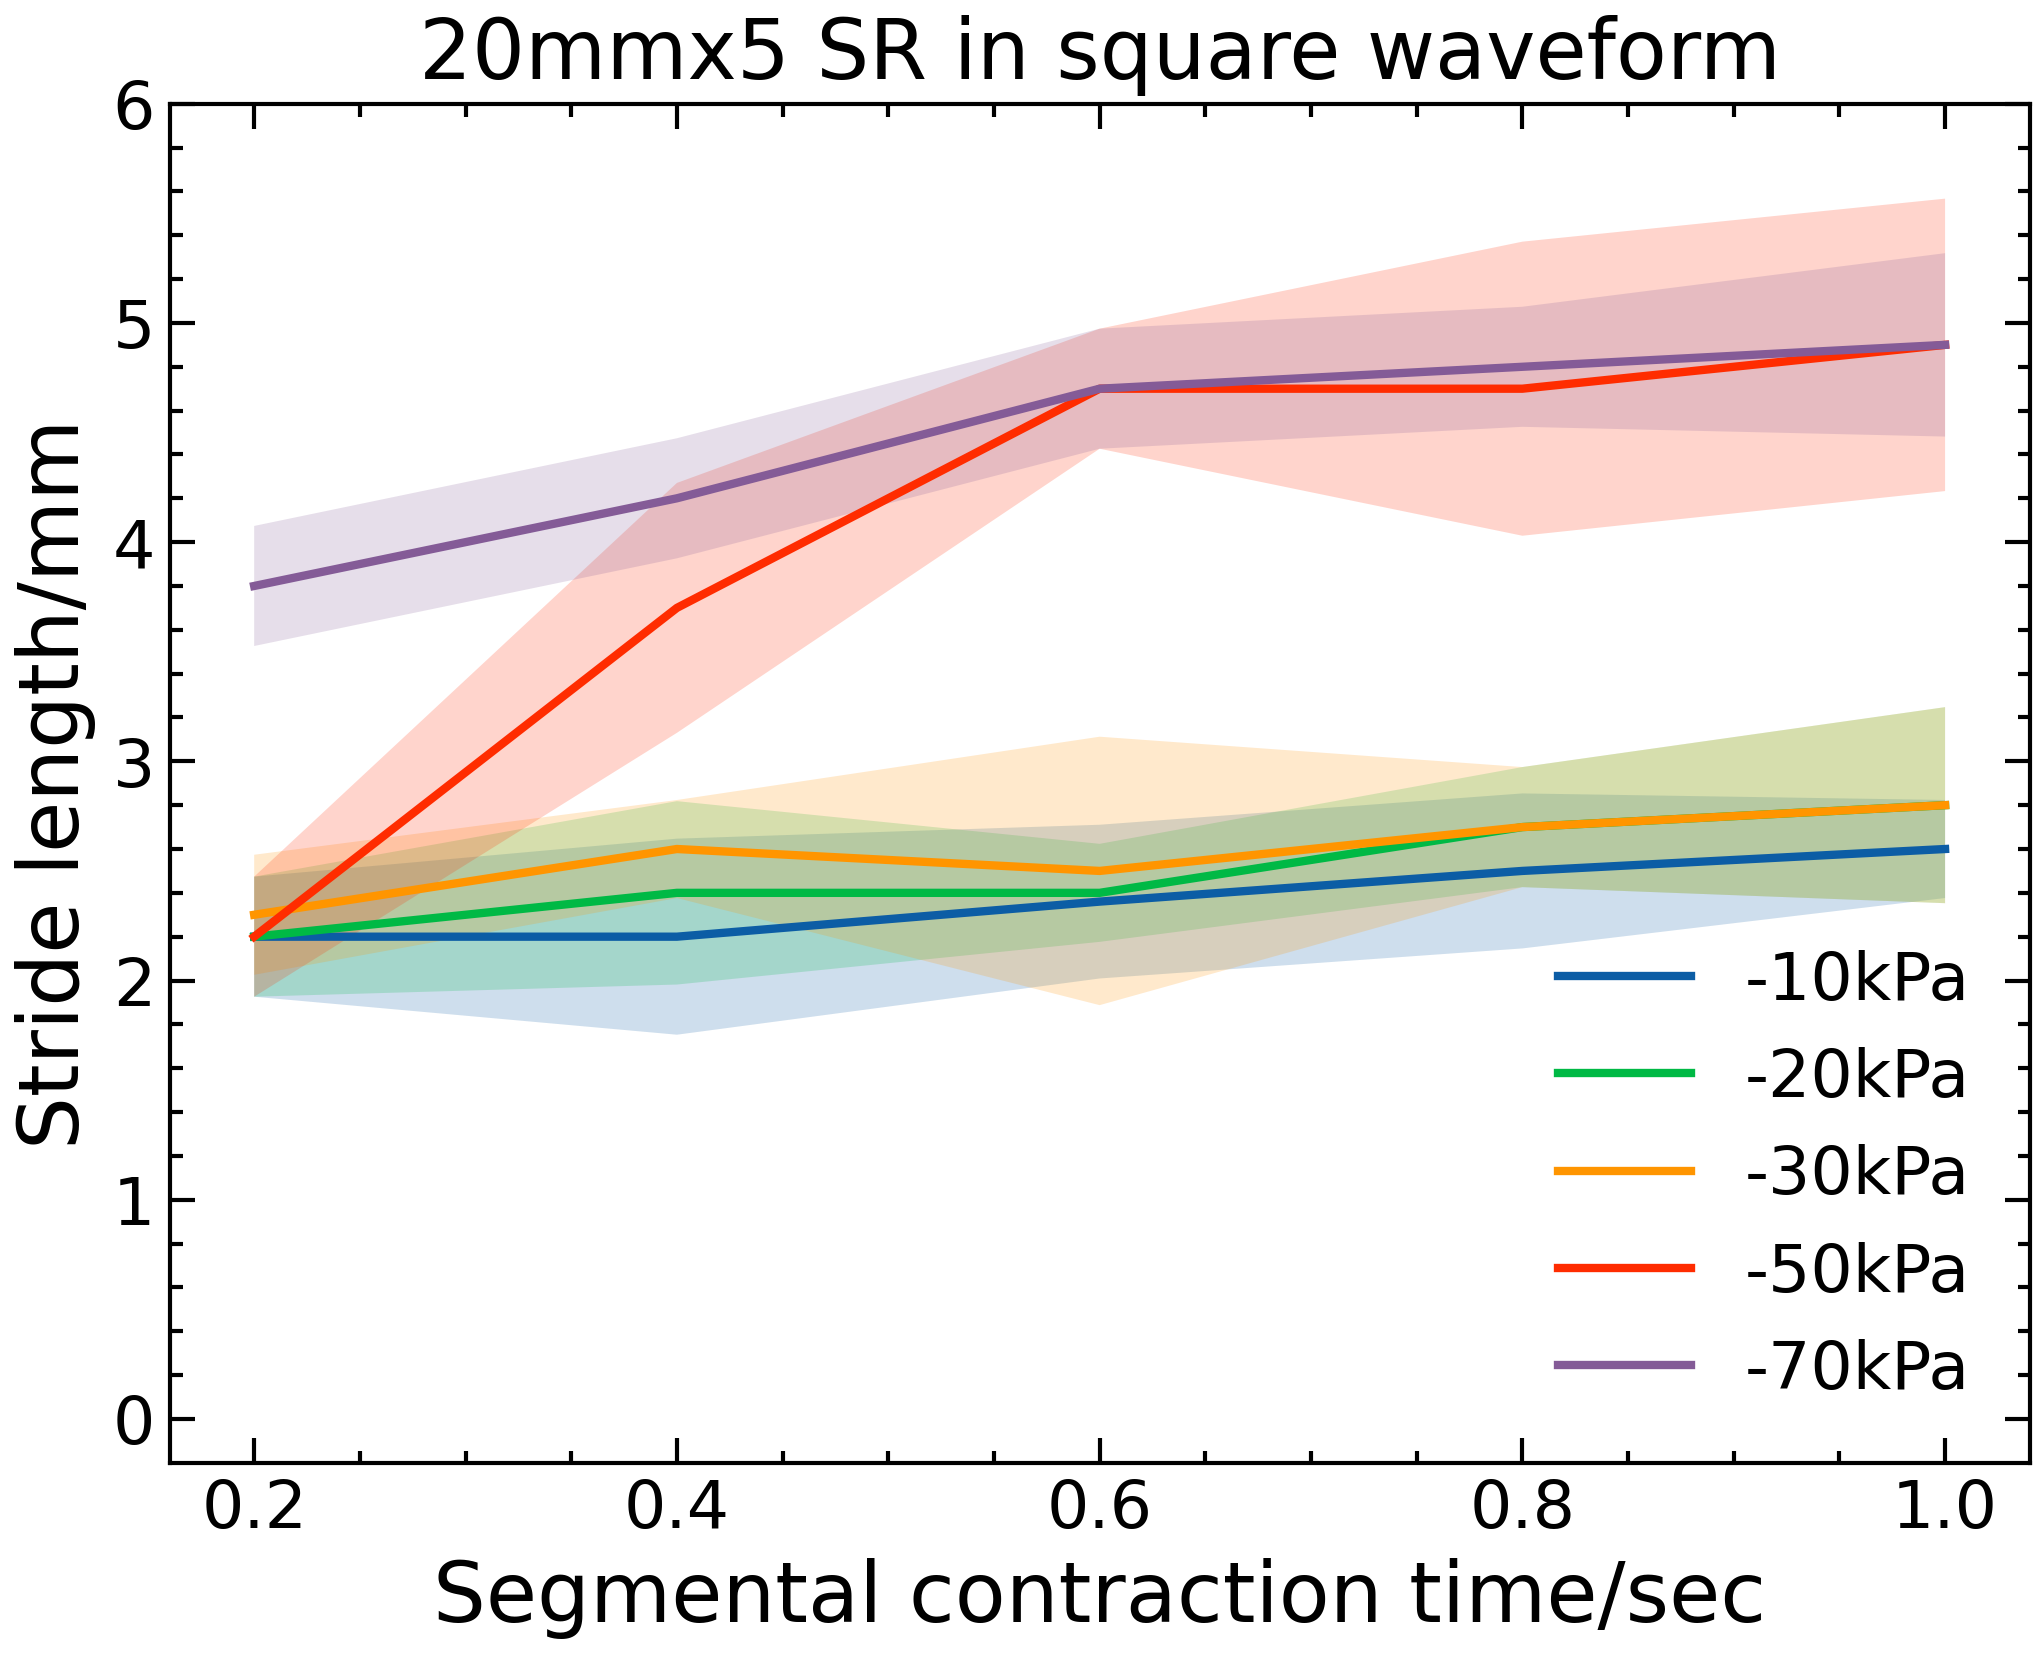

In [54]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import numpy as np

# for 20x5 SR without signal overlapping
x = np.array([0.2, 0.4, 0.6, 0.8, 1])   # stride duration
fre = np.array([1, 1/2, 1/3, 1/4, 1/5])
# for stride data within various waveforms
# p10 = np.array([1.2,	1.3,	1.4,	1.4,	1.2]) 
# p10err = np.array([0.3082207,	0.3082207,	0.141421356,	0.223606798,	0.273861279])
# p20 = np.array([1.1,	1.6,	1.5,	1.3,	1.4])
# p20err = np.array([0.223606798,	0.223606798,	0.3082207,	0.273861279,	0.223606798])
# p30 = np.array([1.7,	1.8,	1.7,	1.9,	2])
# p30err = np.array([0.273861279,	0.273861279,	0.447213595,	0.223606798,	0.353553391])
# p50 = np.array([1.6,	1.8,	2.2,	2.4,	3.1])
# p50err = np.array([0.418330013,	0.570087713,	0.447213595,	0.223606798,	0.418330013])
# p70 = np.array([2.02,	2.3,	3,	3.2,	4.6])
# p70err = np.array([0.14832397,	0.3,	0,	0.273861279,	0.418330013])

p10 = np.array([2.2, 2.2, 2.36, 2.5, 2.6]) 				
p10err = np.array([0.273861279, 0.447213595, 0.350713558, 0.353553391, 0.223606798])				
p20 = np.array([2.2, 2.4, 2.4, 2.7, 2.8])				
p20err = np.array([0.273861279, 0.418330013, 0.223606798, 0.273861279, 0.447213595])				
p30 = np.array([2.3, 2.6, 2.5, 2.7, 2.8])				
p30err = np.array([0.273861279,	0.223606798,	0.612372436,	0.273861279,	0.447213595])
p50 = np.array([2.2,	3.7,	4.7,	4.7,	4.9])
p50err = np.array([0.273861279,	0.570087713,	0.273861279,	0.670820393,	0.667083203])
p70 = np.array([3.8,	4.2,	4.7,	4.8,	4.9])
p70err = np.array([0.273861279,	0.273861279,	0.273861279,	0.273861279,	0.418330013])



# figure plotting
with plt.style.context(['science','notebook','no-latex']):
    fig = plt.figure()
    plt.plot(x, p10, label = '-10kPa')
    plt.fill_between(x, p10-p10err, p10+p10err,alpha=0.2)
    plt.plot(x, p20, label = '-20kPa')
    plt.fill_between(x, p20-p20err, p20+p20err,alpha=0.2)
    plt.plot(x, p30, label = '-30kPa')
    plt.fill_between(x, p30-p30err, p30+p30err,alpha=0.2)
    plt.plot(x, p50, label = '-50kPa')
    plt.fill_between(x, p50-p50err, p50+p50err,alpha=0.2)
    plt.plot(x, p70, label = '-70kPa')
    plt.fill_between(x, p70-p70err, p70+p70err,alpha=0.2)
    # plt.errorbar(x, p10, yerr = p10err, label='-10kPa')
    # plt.errorbar(x, p20, yerr = p20err, label='-20kPa')
    # plt.errorbar(x, p30, yerr = p30err, label='-30kPa')
    # plt.errorbar(x, p50, yerr = p50err, label='-50kPa')
    # plt.errorbar(x, p70, yerr = p70err, label='-70kPa')

    # plt.xlim(1, 5)
    plt.ylim(-0.2, 6)
    ax = plt.gca()
    x_major_locator=MultipleLocator(0.2)
    ax.xaxis.set_major_locator(x_major_locator)
    y_major_locator=MultipleLocator(1)
    ax.yaxis.set_major_locator(y_major_locator)
#     ax.spines['right'].set_visible(False)
#     ax.spines['top'].set_visible(False)
    # the xlabel should be normalized for the phase delay results, which should be replaced with "Segmental  contraction time/s"
    plt.xlabel('Segmental contraction time/sec',fontsize = 20)
    plt.ylabel('Stride length/mm', fontsize = 20)
    plt.title('20mmx5 SR in square waveform', fontsize = 20)
    plt.legend(loc='best') 
    plt.rcParams['savefig.dpi'] = 300 #图片像素
    plt.rcParams['figure.dpi'] = 300
    plt.savefig('SRcrawling20x5-square.png')
    plt.show()

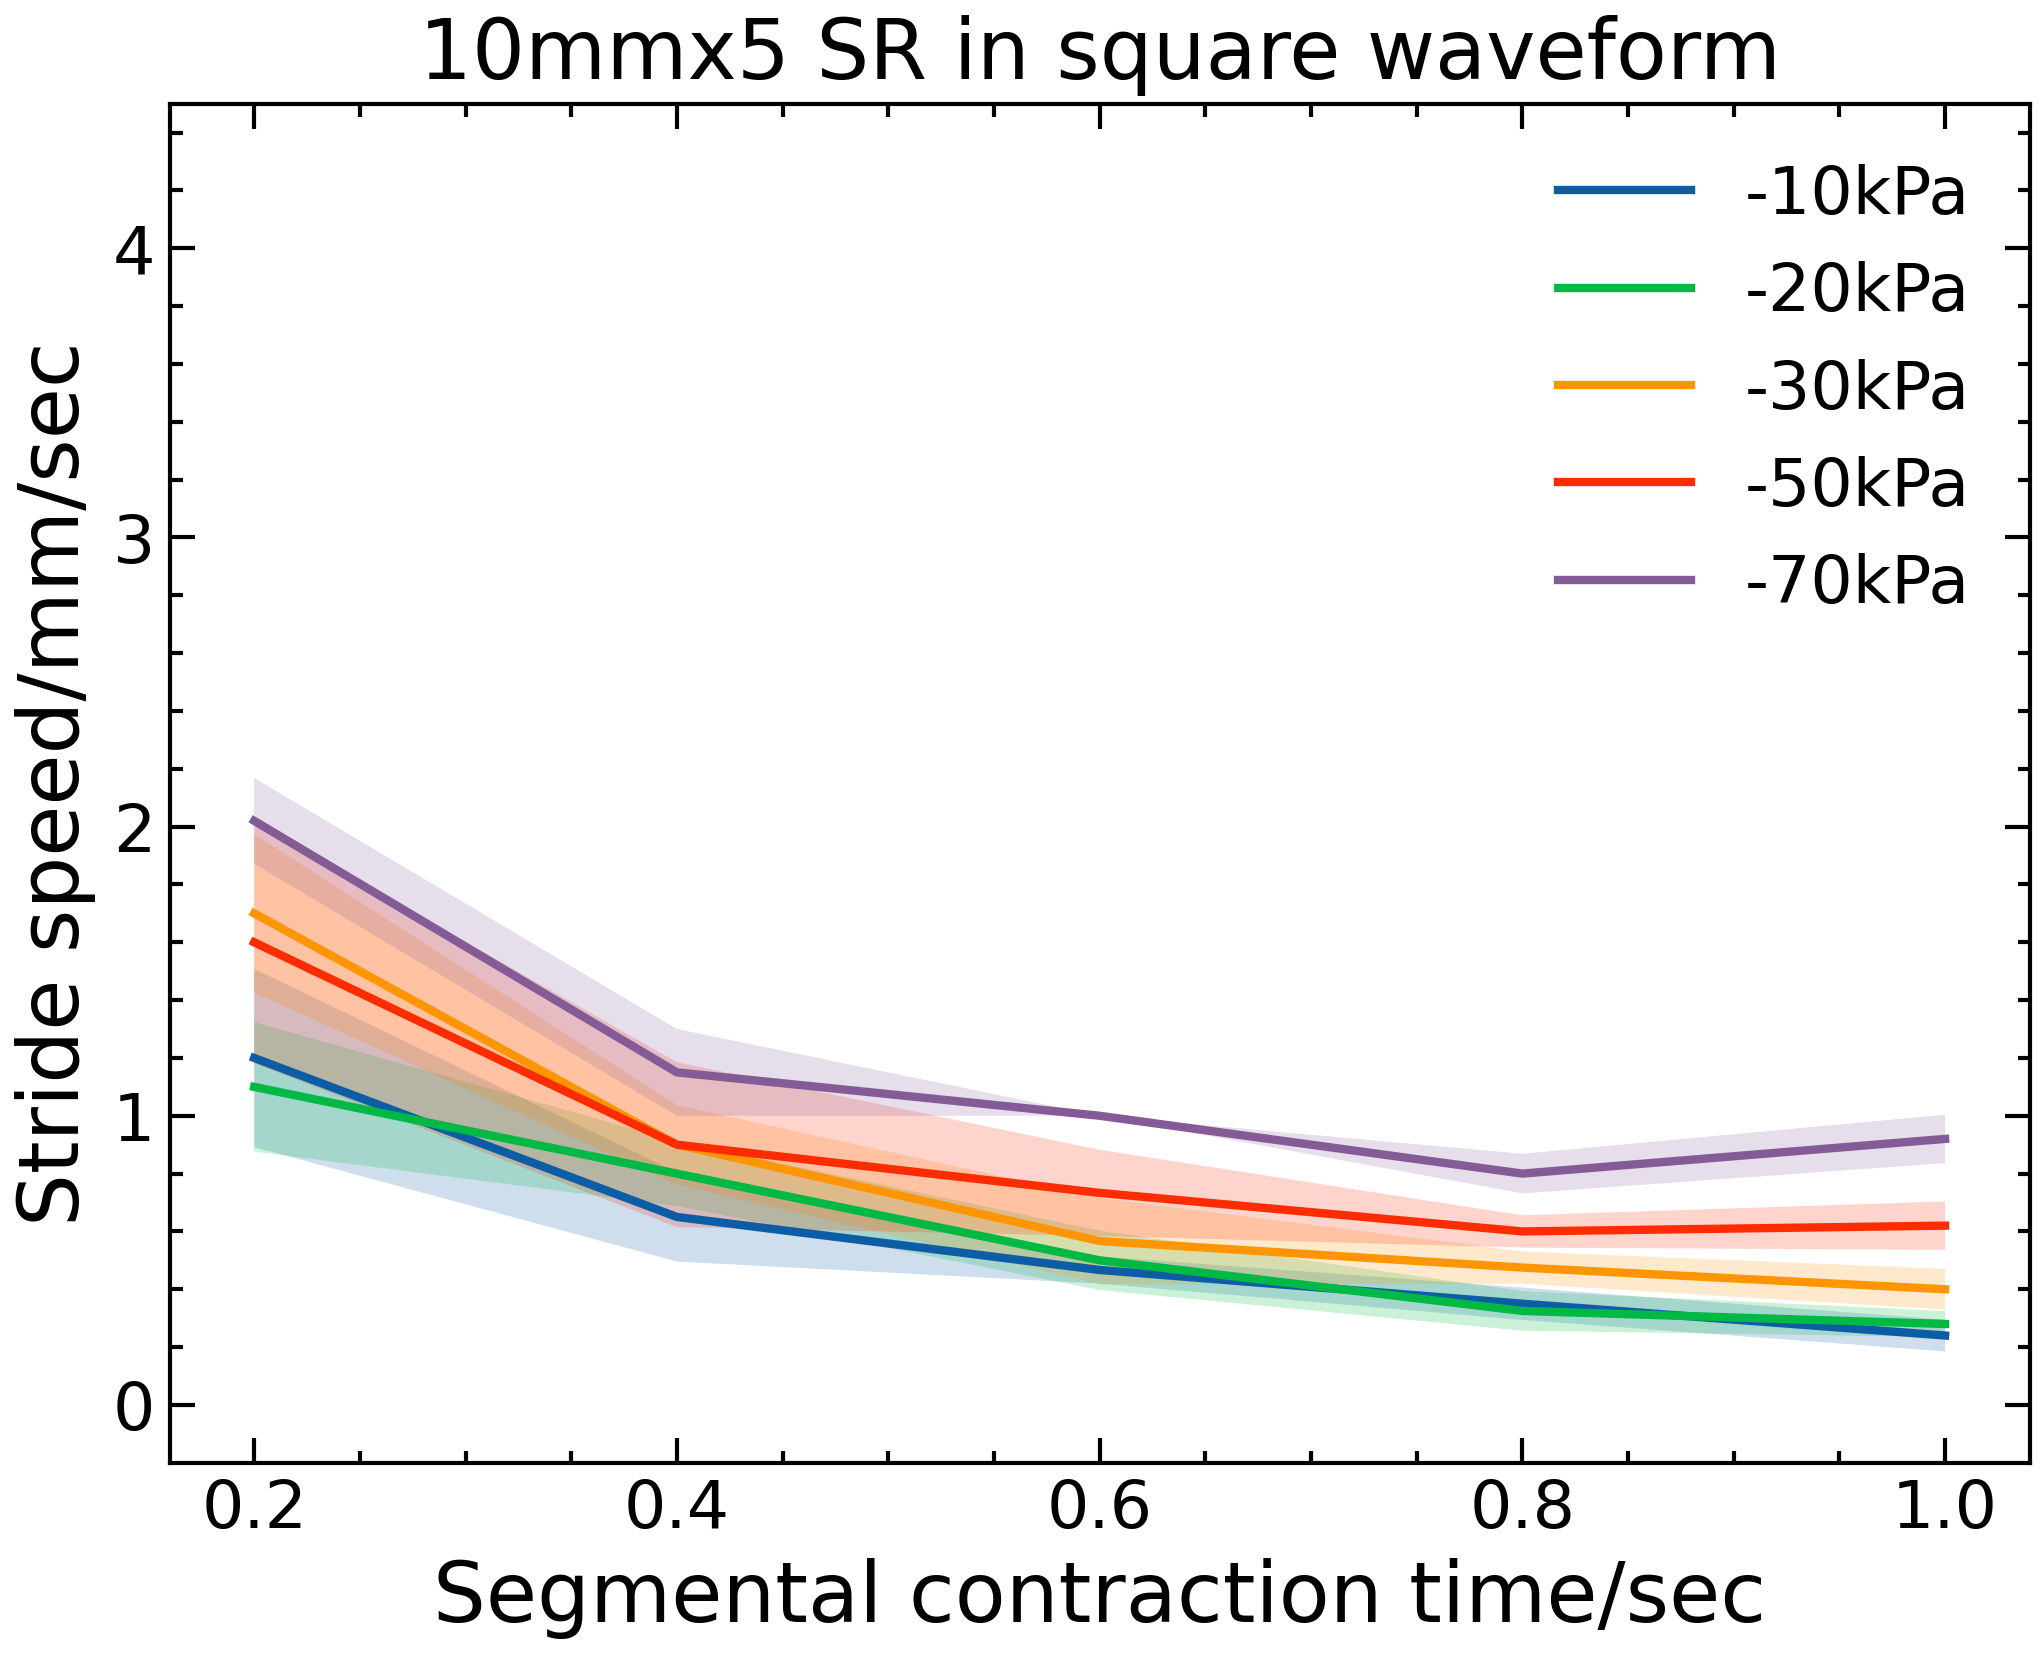

In [55]:
# plot for stride speed

import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import numpy as np

# for 20x5 SR without signal overlapping
x = np.array([0.2, 0.4, 0.6, 0.8, 1])   # stride duration
fre = np.array([1, 1/2, 1/3, 1/4, 1/5])
# for stride data within various waveforms
p10 = np.array([1.2,	1.3,	1.4,	1.4,	1.2]) 
p10err = np.array([0.3082207,	0.3082207,	0.141421356,	0.223606798,	0.273861279])
p20 = np.array([1.1,	1.6,	1.5,	1.3,	1.4])
p20err = np.array([0.223606798,	0.223606798,	0.3082207,	0.273861279,	0.223606798])
p30 = np.array([1.7,	1.8,	1.7,	1.9,	2])
p30err = np.array([0.273861279,	0.273861279,	0.447213595,	0.223606798,	0.353553391])
p50 = np.array([1.6,	1.8,	2.2,	2.4,	3.1])
p50err = np.array([0.418330013,	0.570087713,	0.447213595,	0.223606798,	0.418330013])
p70 = np.array([2.02,	2.3,	3,	3.2,	4.6])
p70err = np.array([0.14832397,	0.3,	0,	0.273861279,	0.418330013])

# p10 = np.array([2.2, 2.2, 2.36, 2.5, 2.6]) 				
# p10err = np.array([0.273861279, 0.447213595, 0.350713558, 0.353553391, 0.223606798])				
# p20 = np.array([2.2, 2.4, 2.4, 2.7, 2.8])				
# p20err = np.array([0.273861279, 0.418330013, 0.223606798, 0.273861279, 0.447213595])				
# p30 = np.array([2.3, 2.6, 2.5, 2.7, 2.8])				
# p30err = np.array([0.273861279,	0.223606798,	0.612372436,	0.273861279,	0.447213595])
# p50 = np.array([2.2,	3.7,	4.7,	4.7,	4.9])
# p50err = np.array([0.273861279,	0.570087713,	0.273861279,	0.670820393,	0.667083203])
# p70 = np.array([3.8,	4.2,	4.7,	4.8,	4.9])
# p70err = np.array([0.273861279,	0.273861279,	0.273861279,	0.273861279,	0.418330013])




# figure plotting
with plt.style.context(['science','notebook','no-latex']):
    fig = plt.figure()
    fig.add_subplot(111)
    plt.plot(x, p10*fre, label = '-10kPa')
    plt.fill_between(x, (p10-p10err)*fre, (p10+p10err)*fre, alpha=0.2)
    plt.plot(x, p20*fre, label = '-20kPa')
    plt.fill_between(x, (p20-p20err)*fre, (p20+p20err)*fre,alpha=0.2)
    plt.plot(x, p30*fre, label = '-30kPa')
    plt.fill_between(x, (p30-p30err)*fre, (p30+p30err)*fre,alpha=0.2)
    plt.plot(x, p50*fre, label = '-50kPa')
    plt.fill_between(x, (p50-p50err)*fre, (p50+p50err)*fre,alpha=0.2)
    plt.plot(x, p70*fre, label = '-70kPa')
    plt.fill_between(x, (p70-p70err)*fre, (p70+p70err)*fre,alpha=0.2)

    # plt.xlim(1, 5)
    plt.ylim(-0.2, 4.5)
    ax = plt.gca()
    x_major_locator=MultipleLocator(0.2)
    ax.xaxis.set_major_locator(x_major_locator)
    y_major_locator=MultipleLocator(1)
    ax.yaxis.set_major_locator(y_major_locator)
    # the xlabel should be normalized for the phase delay results, which should be replaced with "Segmental  contraction time/s"
    plt.xlabel('Segmental contraction time/sec',fontsize = 20)
    plt.ylabel('Stride speed/mm/sec', fontsize = 20)
    plt.title('10mmx5 SR in square waveform', fontsize = 20)
    plt.legend(loc='upper right') 
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'
    plt.rcParams['savefig.dpi'] = 300 #图片像素
    plt.rcParams['figure.dpi'] = 300
    plt.savefig('SRcrawlingSpeed10x5-square.png')
    plt.show()

### 3） Plot for backward in various stride duration

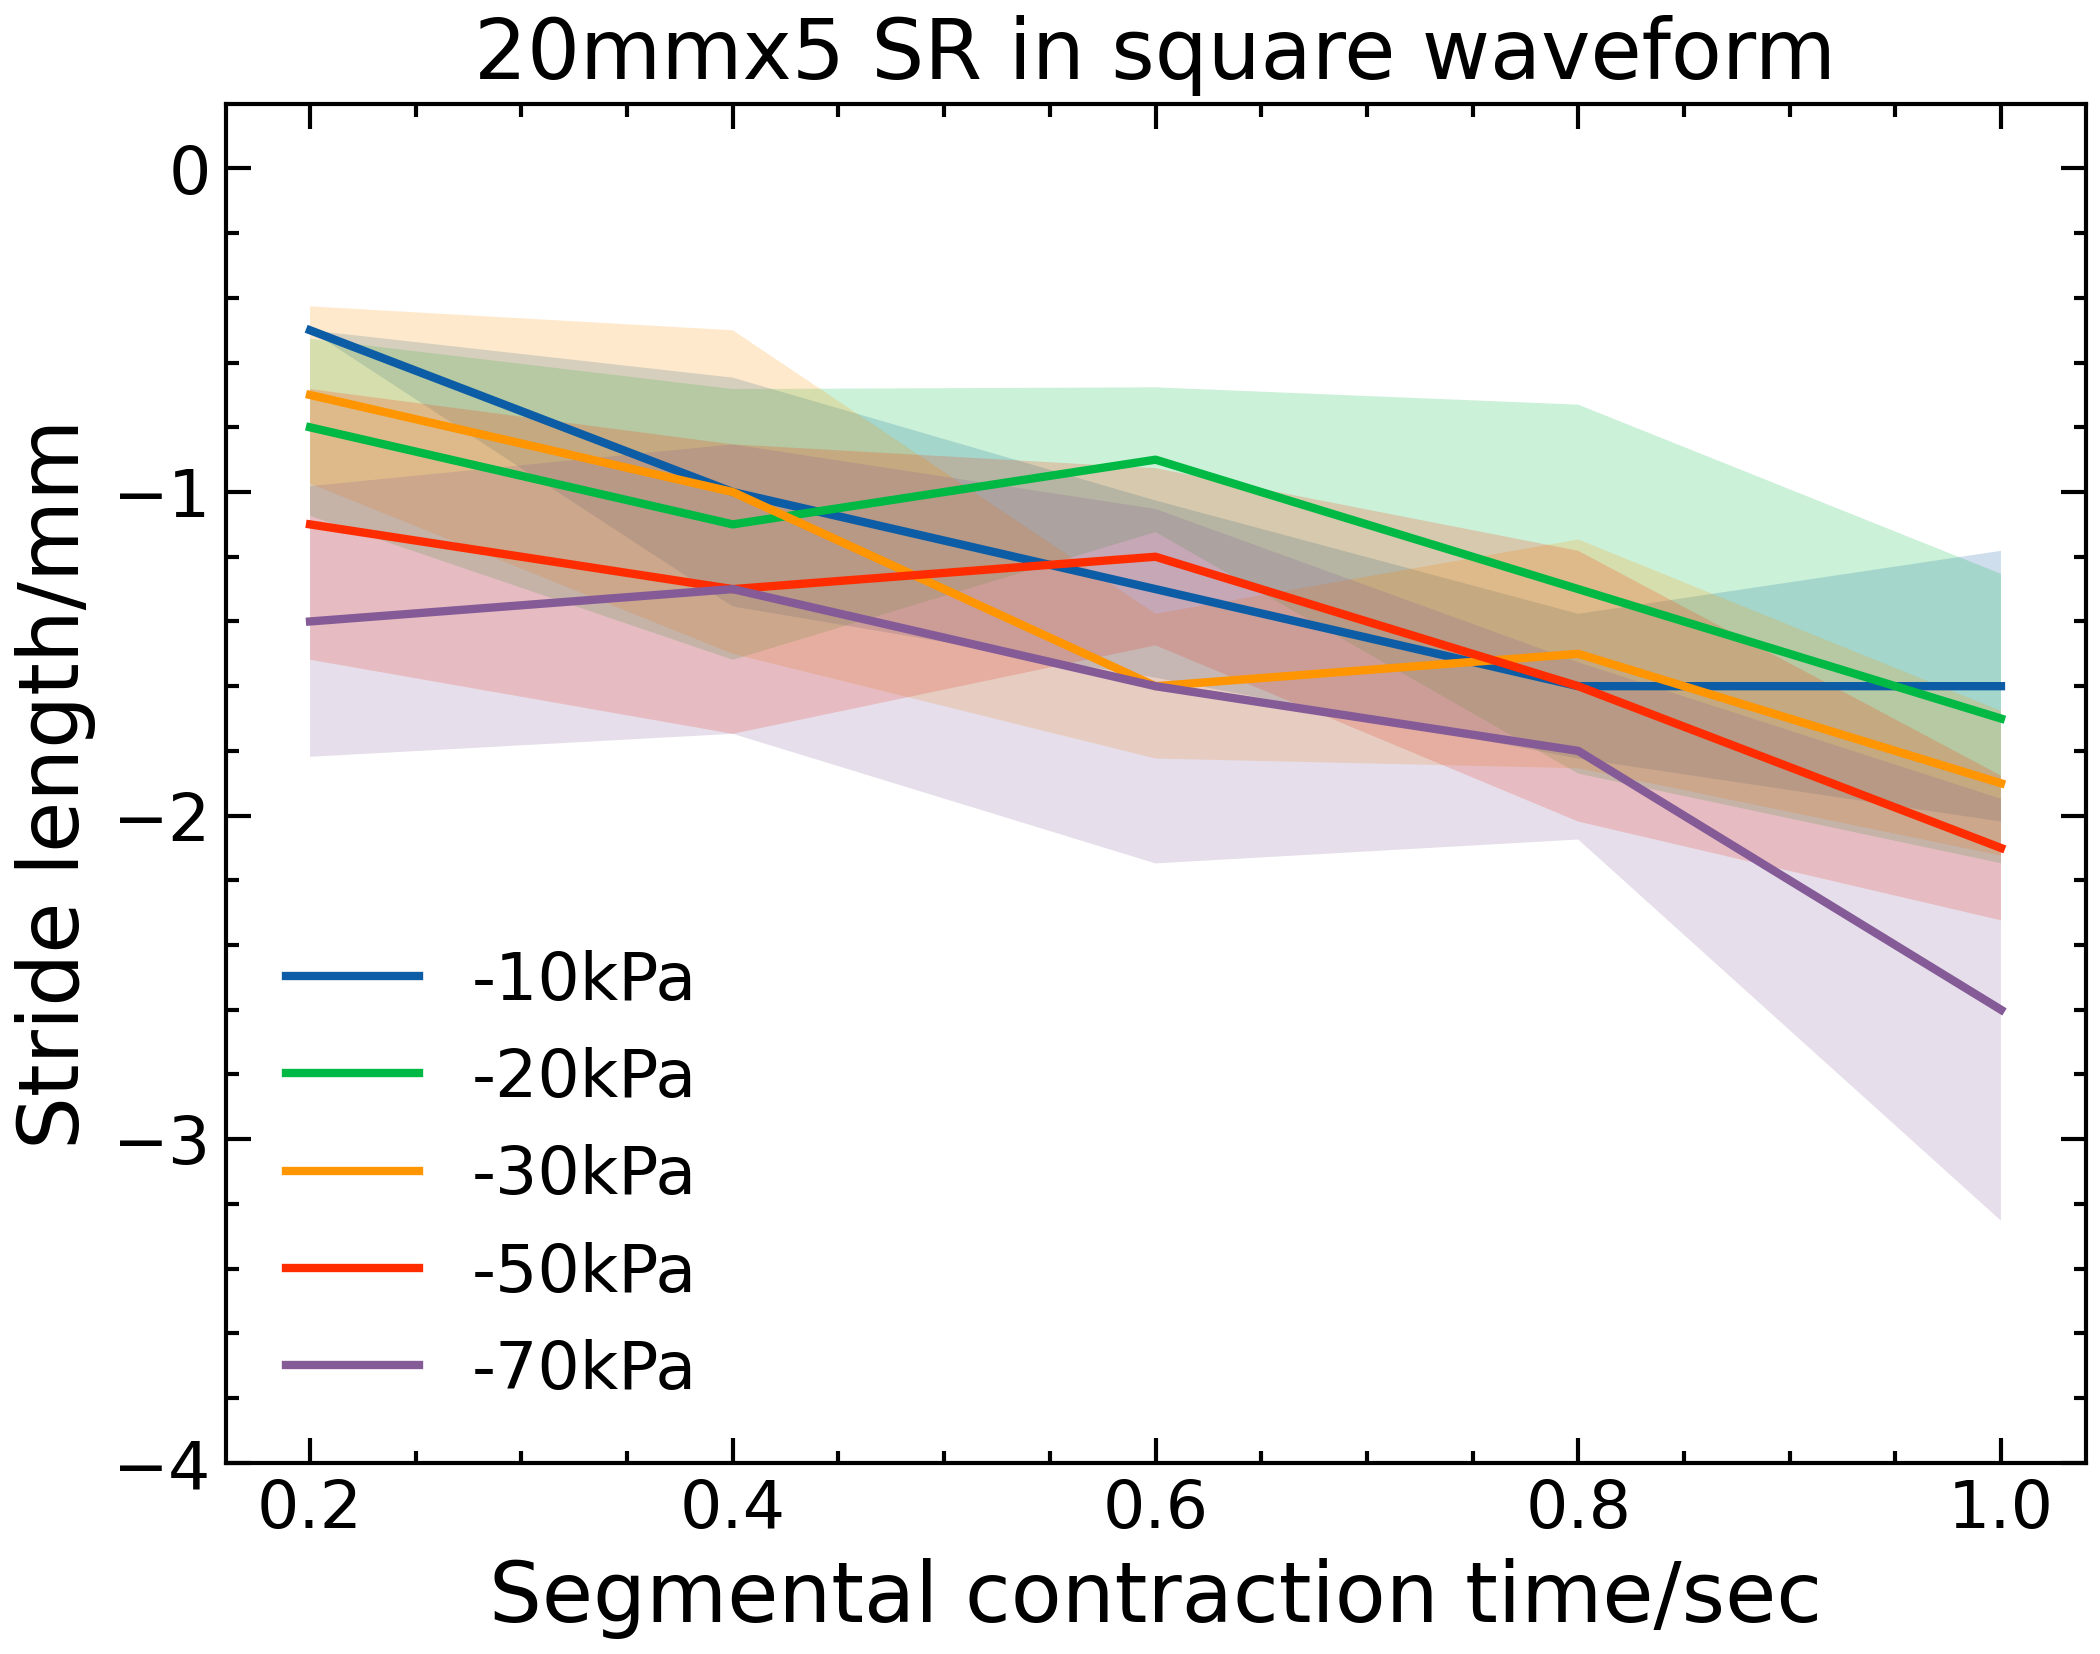

In [51]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import numpy as np

# for 20x5 SR without signal overlapping
x = np.array([0.2, 0.4, 0.6, 0.8, 1])   # stride duration
# for stride data within various waveforms
p10 = np.array([-0.5,	-1,	-1.3,	-1.6,	-1.6]) 
p10err = np.array([0,	0.353553391,	0.273861279,	0.223606798,	0.418330013])
p20 = np.array([-0.8,	-1.1,	-0.9,	-1.3,	-1.7])	
p20err = np.array([0.273861279,	0.418330013,	0.223606798,	0.570087713,	0.447213595])
p30 = np.array([-0.7,	-1,	-1.6,	-1.5,	-1.9])
p30err = np.array([0.273861279,	0.5,	0.223606798,	0.353553391,	0.223606798])
p50 = np.array([-1.1,	-1.3,	-1.2,	-1.6,	-2.1])
p50err = np.array([0.418330013,	0.447213595,	0.273861279,	0.418330013,	0.223606798])
p70 = np.array([-1.4,	-1.3,	-1.6,	-1.8,	-2.6])
p70err = np.array([0.418330013,	0.447213595,	0.547722558,	0.273861279,	0.651920241])


# figure plotting
with plt.style.context(['science','notebook','no-latex']):
    fig = plt.figure()
    fig.add_subplot(111)
    plt.plot(x, p10, label = '-10kPa')
    plt.fill_between(x, p10-p10err, p10+p10err,alpha=0.2)
    plt.plot(x, p20, label = '-20kPa')
    plt.fill_between(x, p20-p20err, p20+p20err,alpha=0.2)
    plt.plot(x, p30, label = '-30kPa')
    plt.fill_between(x, p30-p30err, p30+p30err,alpha=0.2)
    plt.plot(x, p50, label = '-50kPa')
    plt.fill_between(x, p50-p50err, p50+p50err,alpha=0.2)
    plt.plot(x, p70, label = '-70kPa')
    plt.fill_between(x, p70-p70err, p70+p70err,alpha=0.2)

    # plt.xlim(1, 5)
    plt.ylim(-4, 0.2)
    ax = plt.gca()
    x_major_locator=MultipleLocator(0.2)
    ax.xaxis.set_major_locator(x_major_locator)
    y_major_locator=MultipleLocator(1)
    ax.yaxis.set_major_locator(y_major_locator)
    # the xlabel should be normalized for the phase delay results, which should be replaced with "Segmental  contraction time/s"
    plt.xlabel('Segmental contraction time/sec',fontsize = 20)
    plt.ylabel('Stride length/mm', fontsize = 20)
    plt.title('20mmx5 SR in square waveform', fontsize = 20)
    plt.legend(loc='lower left') 
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'
    plt.rcParams['savefig.dpi'] = 300 #图片像素
    plt.rcParams['figure.dpi'] = 300
    plt.savefig('SRcrawling20x5-square-B.png')
    plt.show()

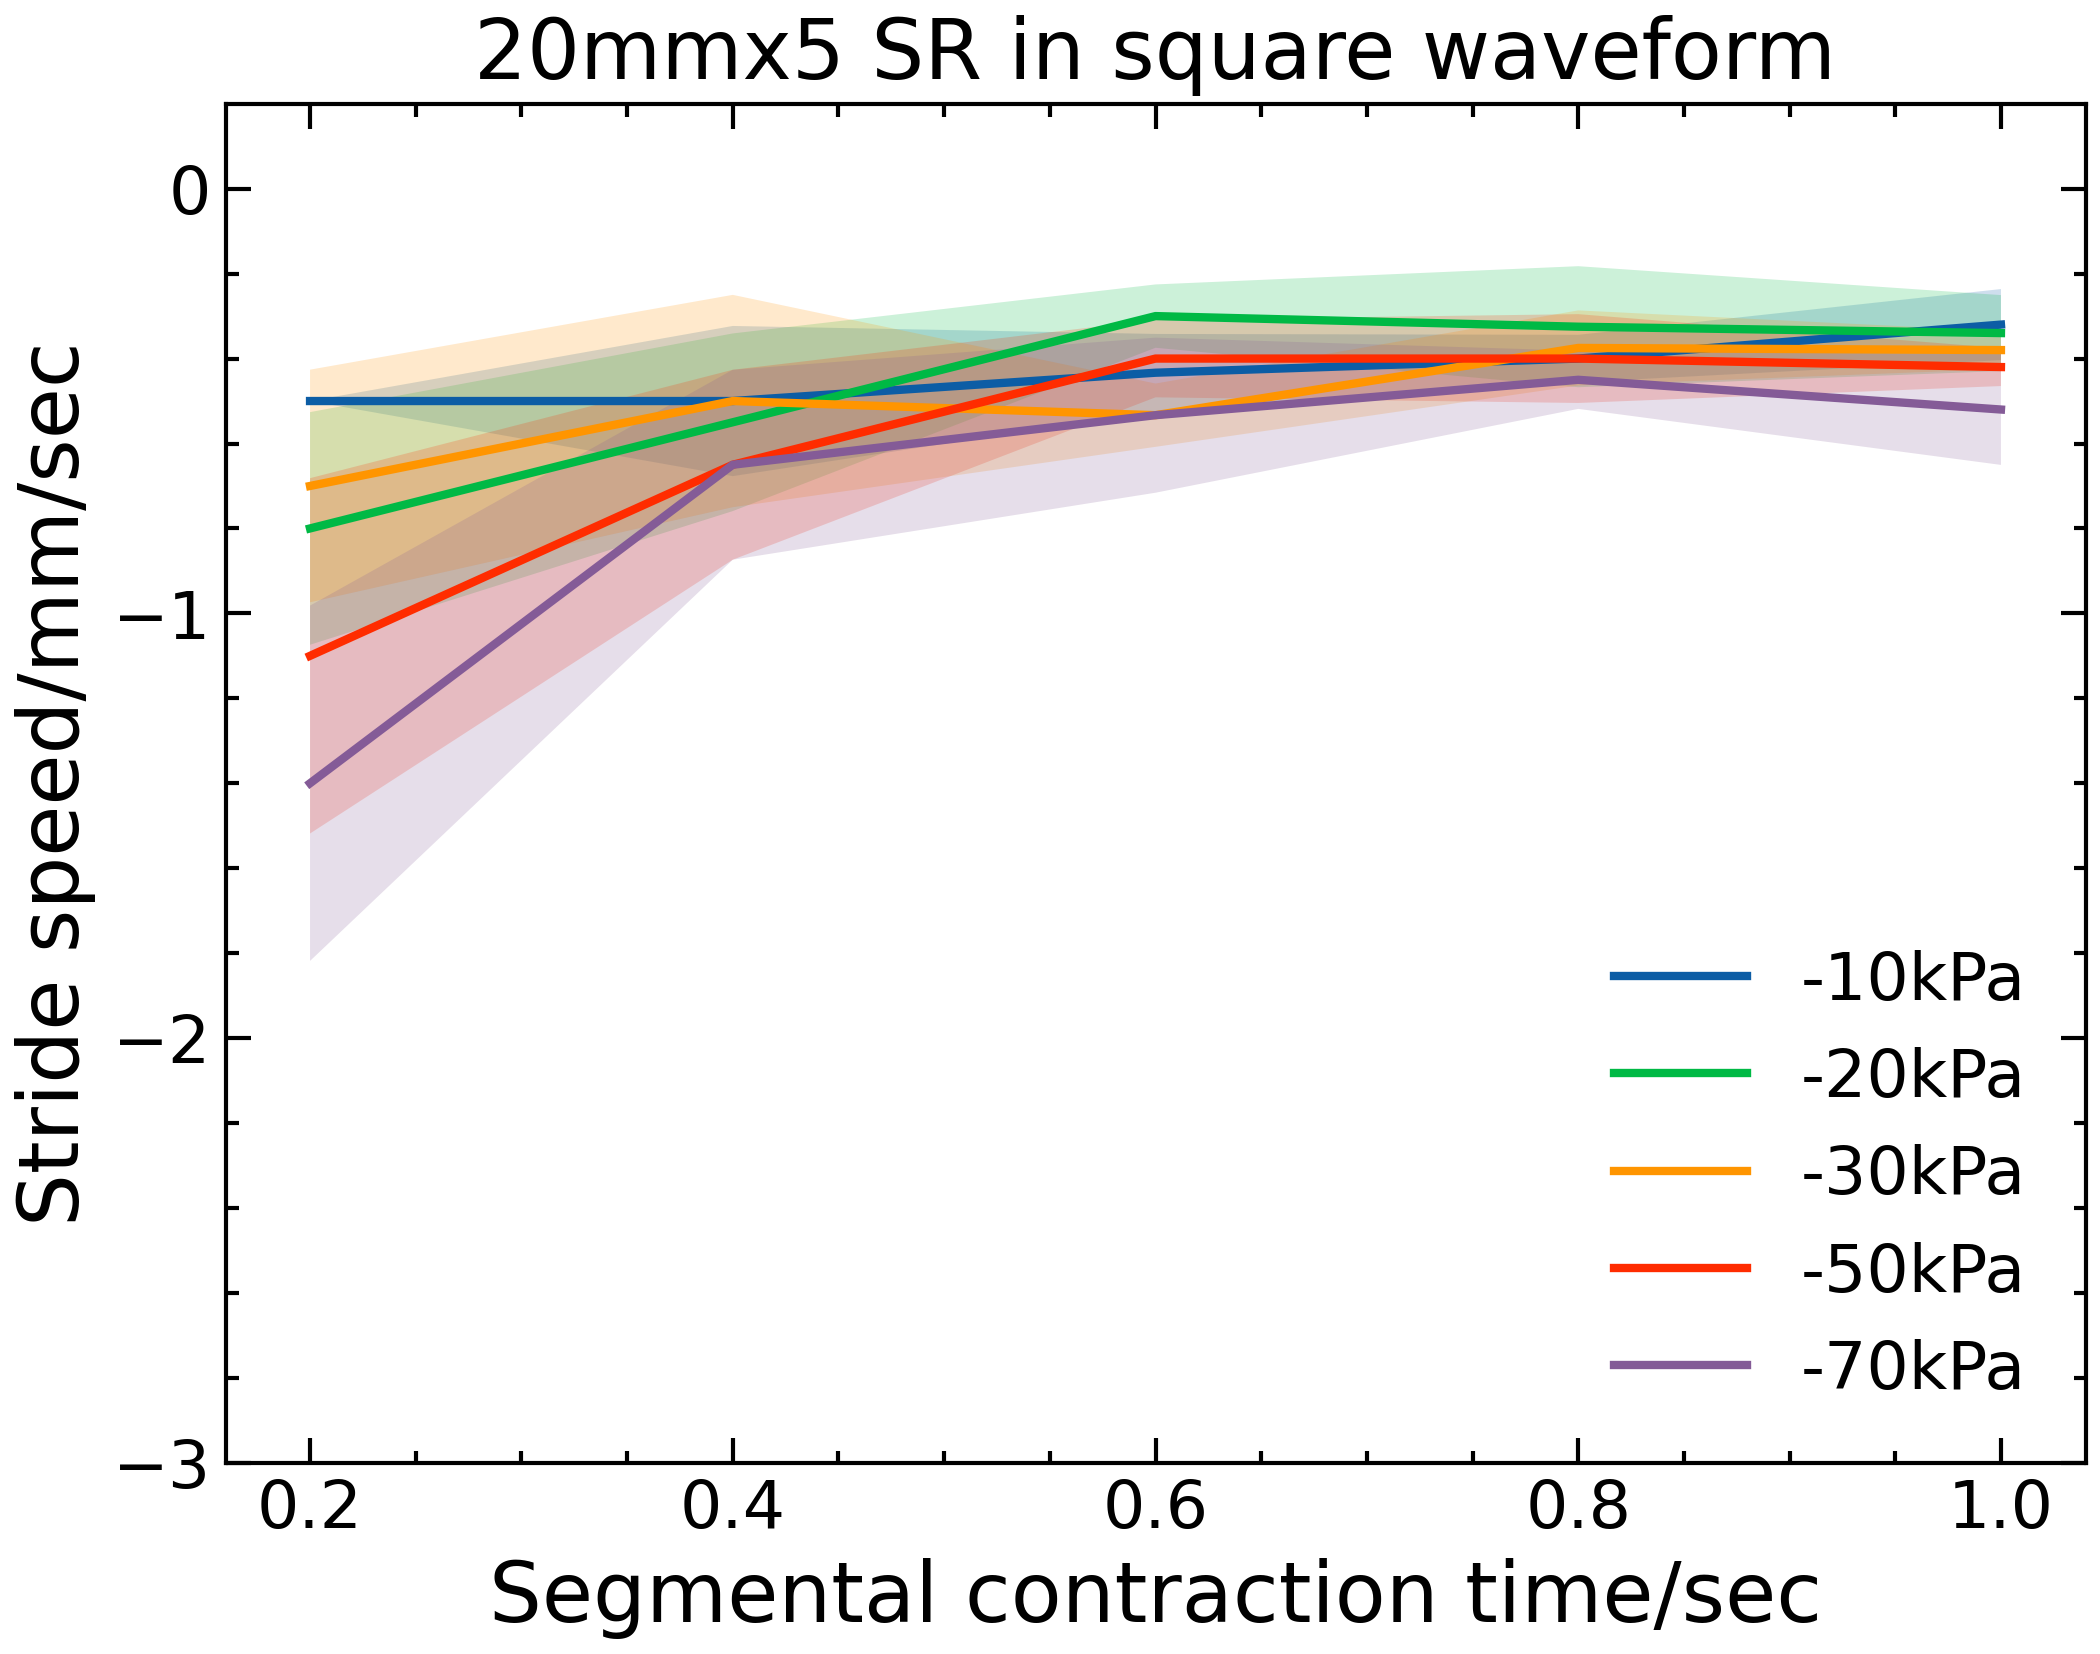

In [50]:
# plot for stride speed in backward under diverse pressures
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import numpy as np

# for 20x5 SR without signal overlapping
x = np.array([0.2, 0.4, 0.6, 0.8, 1])   # stride duration
# for stride data within various waveforms
fre = np.array([1, 1/2, 1/3, 1/4, 1/5])
p10 = np.array([-0.5,	-1,	-1.3,	-1.6,	-1.6]) 
p10err = np.array([0,	0.353553391,	0.273861279,	0.223606798,	0.418330013])
p20 = np.array([-0.8,	-1.1,	-0.9,	-1.3,	-1.7])	
p20err = np.array([0.273861279,	0.418330013,	0.223606798,	0.570087713,	0.447213595])
p30 = np.array([-0.7,	-1,	-1.6,	-1.5,	-1.9])
p30err = np.array([0.273861279,	0.5,	0.223606798,	0.353553391,	0.223606798])
p50 = np.array([-1.1,	-1.3,	-1.2,	-1.6,	-2.1])
p50err = np.array([0.418330013,	0.447213595,	0.273861279,	0.418330013,	0.223606798])
p70 = np.array([-1.4,	-1.3,	-1.6,	-1.8,	-2.6])
p70err = np.array([0.418330013,	0.447213595,	0.547722558,	0.273861279,	0.651920241])



# figure plotting
with plt.style.context(['science','notebook','no-latex']):
    fig = plt.figure()
    fig.add_subplot(111)
    plt.plot(x, p10*fre, label = '-10kPa')
    plt.fill_between(x, (p10-p10err)*fre, (p10+p10err)*fre,alpha=0.2)
    plt.plot(x, p20*fre, label = '-20kPa')
    plt.fill_between(x, (p20-p20err)*fre, (p20+p20err)*fre,alpha=0.2)
    plt.plot(x, p30*fre, label = '-30kPa')
    plt.fill_between(x, (p30-p30err)*fre, (p30+p30err)*fre,alpha=0.2)
    plt.plot(x, p50*fre, label = '-50kPa')
    plt.fill_between(x, (p50-p50err)*fre, (p50+p50err)*fre,alpha=0.2)
    plt.plot(x, p70*fre, label = '-70kPa')
    plt.fill_between(x, (p70-p70err)*fre, (p70+p70err)*fre,alpha=0.2)

    # plt.xlim(1, 5)
    plt.ylim(-3, 0.2)
    ax = plt.gca()
    x_major_locator=MultipleLocator(0.2)
    ax.xaxis.set_major_locator(x_major_locator)
    y_major_locator=MultipleLocator(1)
    ax.yaxis.set_major_locator(y_major_locator)
    # the xlabel should be normalized for the phase delay results, which should be replaced with "Segmental  contraction time/s"
    plt.xlabel('Segmental contraction time/sec',fontsize = 20)
    plt.ylabel('Stride speed/mm/sec', fontsize = 20)
    plt.title('20mmx5 SR in square waveform', fontsize = 20)
    plt.legend(loc='lower right') 
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'
    plt.rcParams['savefig.dpi'] = 300 #图片像素
    plt.rcParams['figure.dpi'] = 300
    plt.savefig('SRcrawlingSoeed20x5-square-B.png')
    plt.show()

### 4) Plot for various segmental phase delay

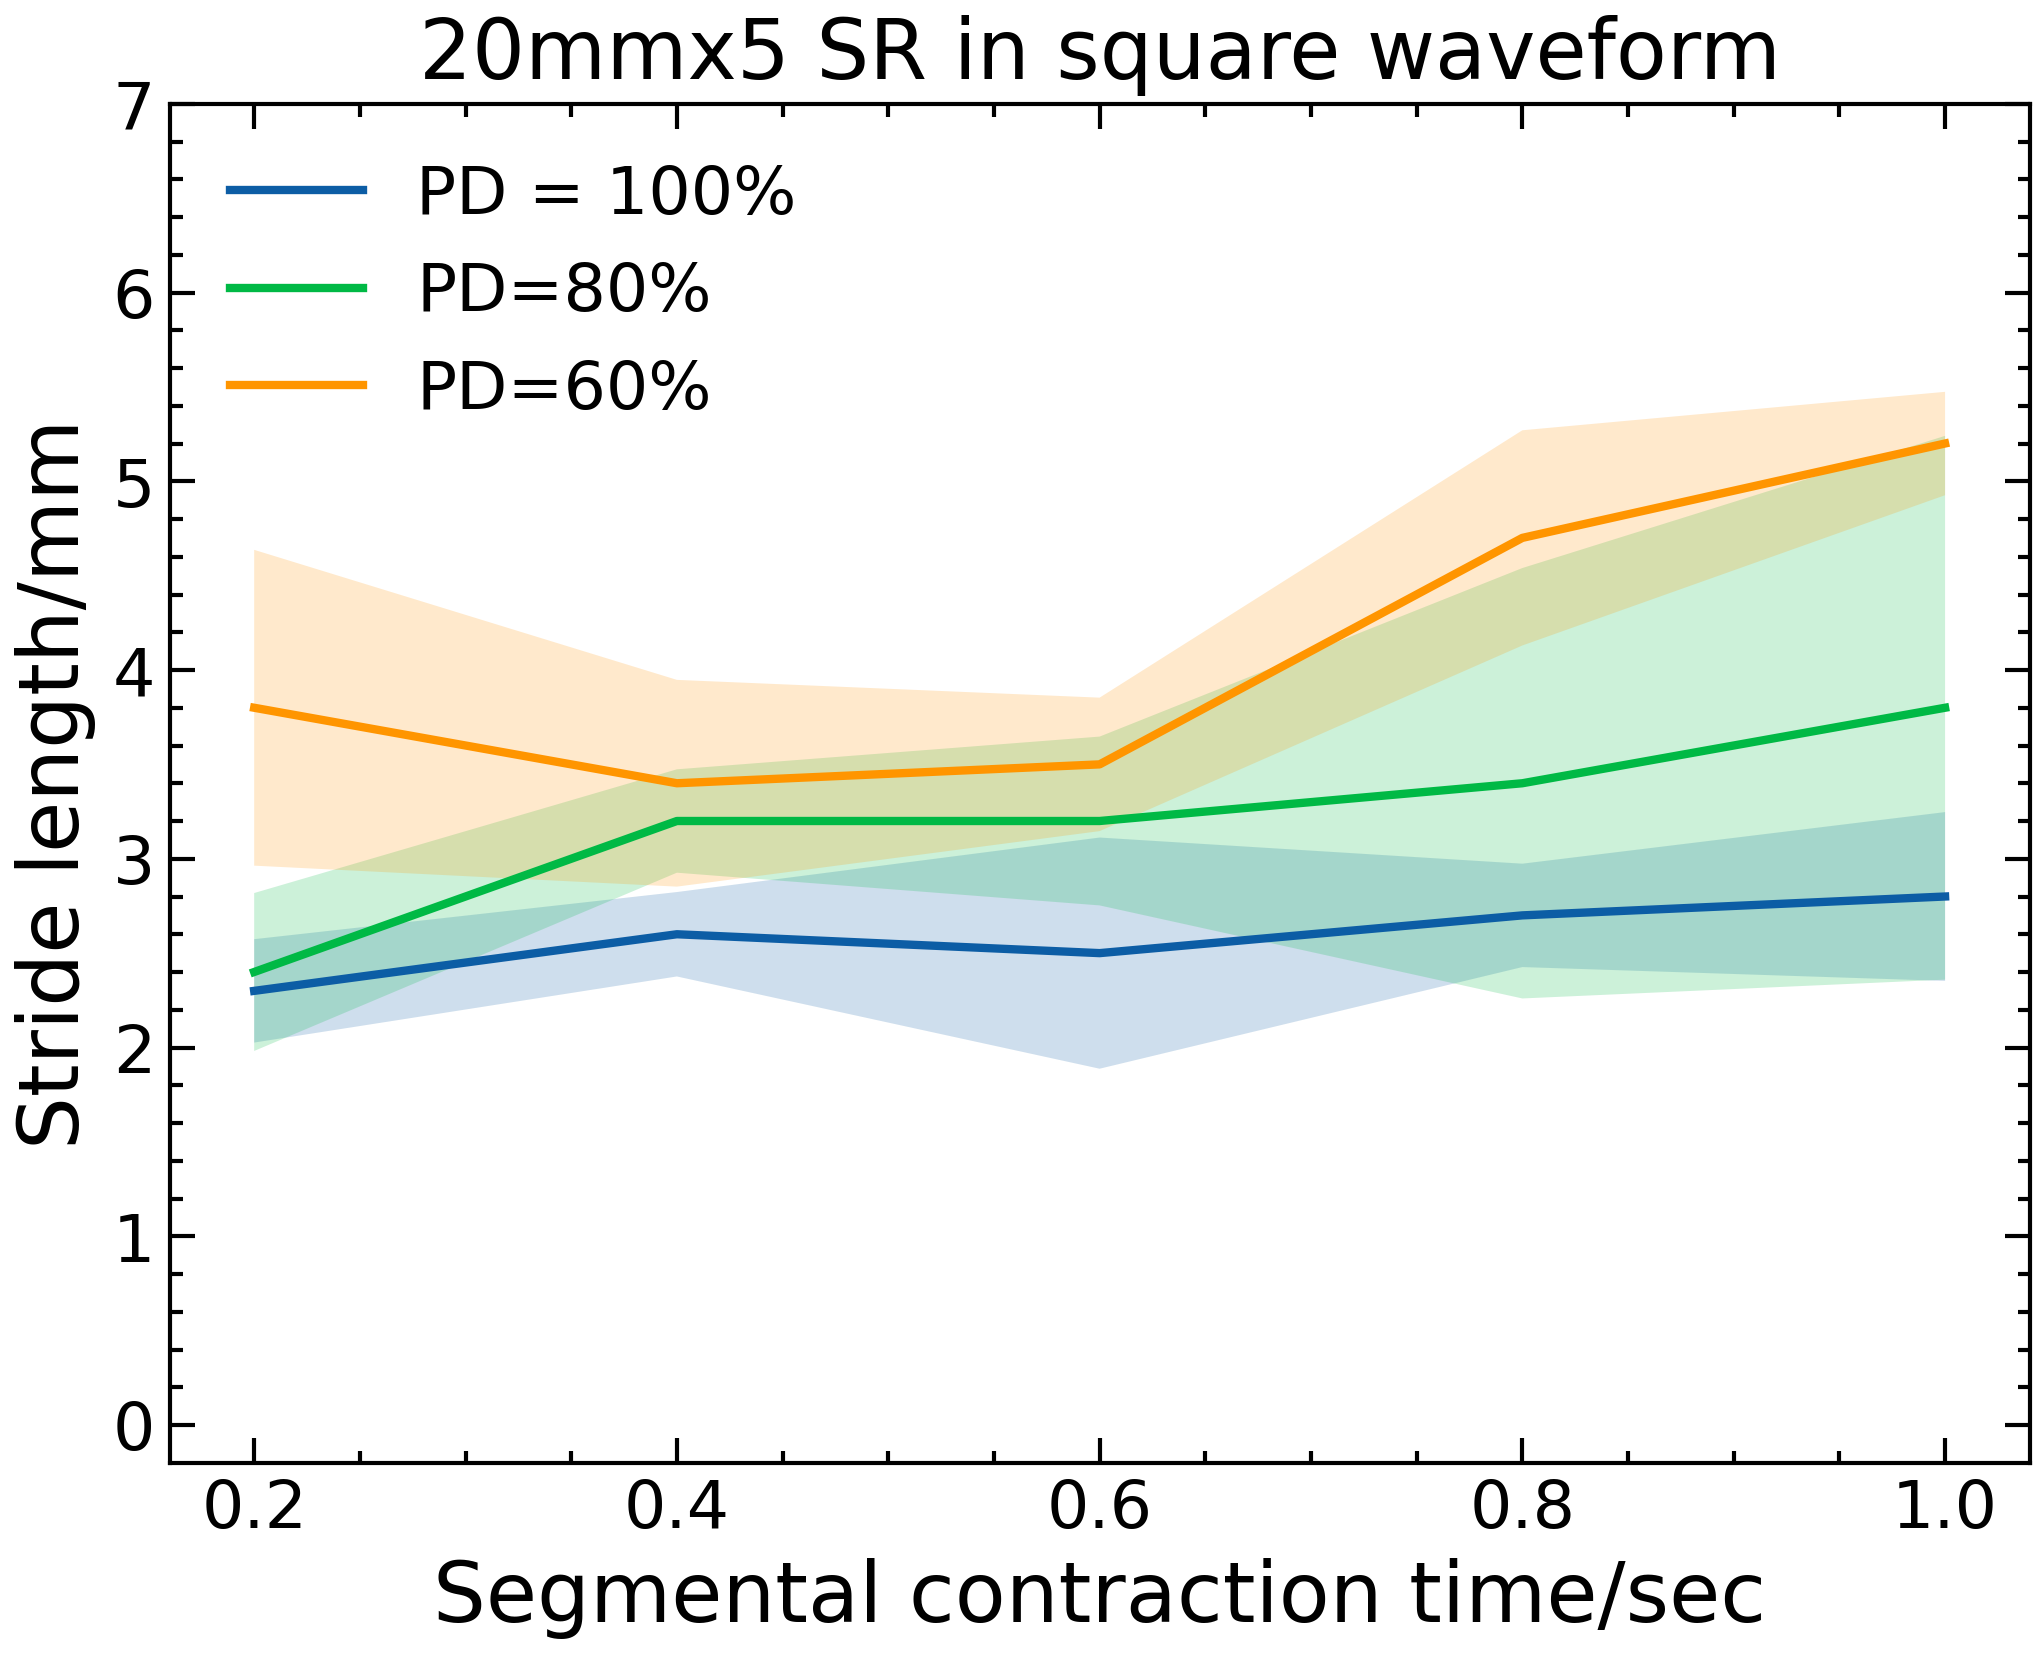

In [49]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import numpy as np

# for 20x5 SR without signal overlapping
x = np.array([0.2, 0.4, 0.6, 0.8, 1])   # stride duration
# for stride data within various waveforms
fre1 = np.array([1, 1/2, 1/3, 1/4, 1/5])
fre2 = np.array([1/0.8, 1/1.6, 1/2.4, 1/3.2, 1/4])
fre3 = np.array([1/0.6, 1/1.2, 1/1.8, 1/2.4, 1/3])

# PD0 = np.array([1.7,	1.8,	1.7,	1.9,	2]) 
# PD0err = np.array([0.273861279,	0.273861279,	0.447213595,	0.223606798,	0.353553391])
# PD20 = np.array([3.3,	3.5,	4.9,	5,	5])
# PD20err = np.array([0.974679434,	0.707106781,	0.651920241,	0.612372436,	0])
# PD40 = np.array([2.7,	4.5,	5,	5.8,	5.7])
# PD40err = np.array([0.447213595,	0.5,	0.353553391,	0.273861279,	0.273861279])

PD0 = np.array([2.3,	2.6,	2.5,	2.7,	2.8]) 
PD0err = np.array([0.273861279,	0.223606798,	0.612372436,	0.273861279,	0.447213595])
PD20 = np.array([2.4,	3.2,	3.2,	3.4,	3.8])
PD20err = np.array([0.418330013,	0.273861279,	0.447213595,	1.140175425,	1.440486029])
PD40 = np.array([3.8,	3.4,	3.5,	4.7,	5.2])
PD40err = np.array([0.836660027,	0.547722558,	0.353553391,	0.570087713,	0.273861279])

# figure plotting
with plt.style.context(['science','notebook','no-latex']):
    fig = plt.figure()
    fig.add_subplot(111)
    plt.plot(x, PD0, label = 'PD = 100%')
    plt.fill_between(x, PD0-PD0err, PD0+PD0err,alpha=0.2)
    plt.plot(x, PD20, label = 'PD=80%')
    plt.fill_between(x, PD20-PD20err, PD20+PD20err,alpha=0.2)
    plt.plot(x, PD40, label = 'PD=60%')
    plt.fill_between(x, PD40-PD40err, PD40+PD40err,alpha=0.2)

    # plt.xlim(1, 5)
    plt.ylim(-0.2, 7)
    ax = plt.gca()
    x_major_locator=MultipleLocator(0.2)
    ax.xaxis.set_major_locator(x_major_locator)
    y_major_locator=MultipleLocator(1)
    ax.yaxis.set_major_locator(y_major_locator)
    # the xlabel should be normalized for the phase delay results, which should be replaced with "Segmental  contraction time/s"
    plt.xlabel('Segmental contraction time/sec',fontsize = 20)
    plt.ylabel('Stride length/mm', fontsize = 20)
    plt.title('20mmx5 SR in square waveform', fontsize = 20)
    plt.legend(loc='upper left') 
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'
    plt.rcParams['savefig.dpi'] = 300 #图片像素
    plt.rcParams['figure.dpi'] = 300
    plt.savefig('SRcrawling20x5-square-PD.png')
    plt.show()

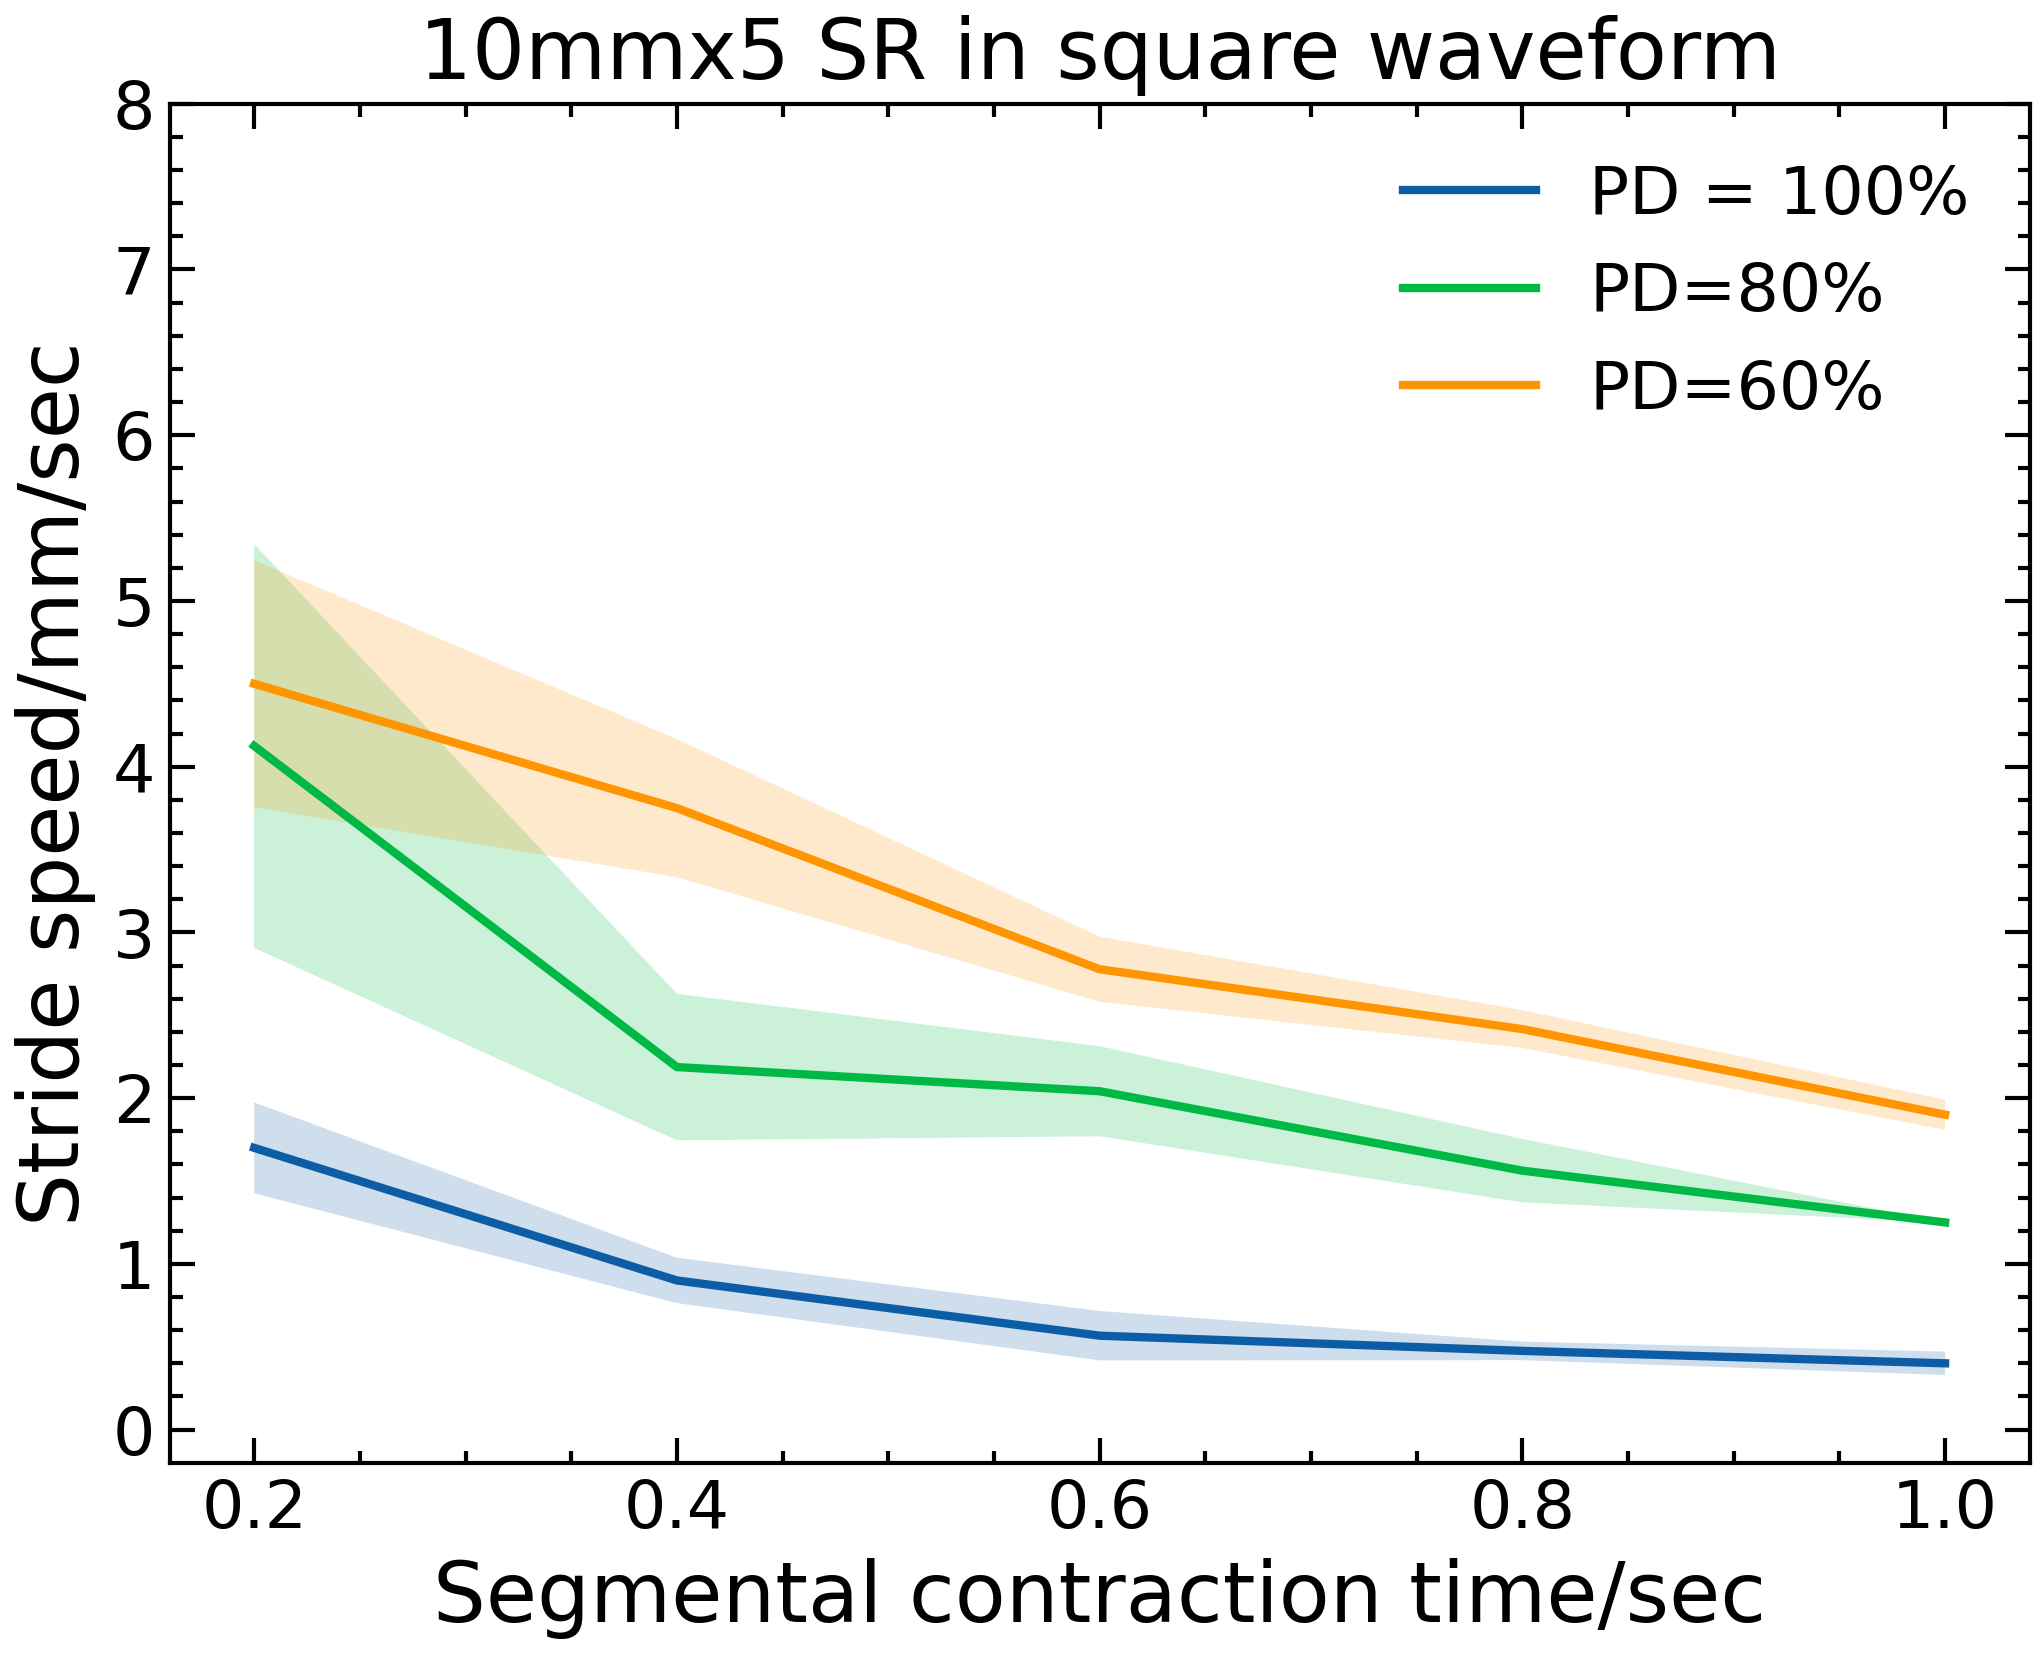

In [47]:
# plot for stride speed under diverse segmental phase delay
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import numpy as np

# for 20x5 SR without signal overlapping
x = np.array([0.2, 0.4, 0.6, 0.8, 1])   # stride duration
# for stride data within various waveforms
fre1 = np.array([1, 1/2, 1/3, 1/4, 1/5])
fre2 = np.array([1/0.8, 1/1.6, 1/2.4, 1/3.2, 1/4])
fre3 = np.array([1/0.6, 1/1.2, 1/1.8, 1/2.4, 1/3])

PD0 = np.array([1.7,	1.8,	1.7,	1.9,	2]) 
PD0err = np.array([0.273861279,	0.273861279,	0.447213595,	0.223606798,	0.353553391])
PD20 = np.array([3.3,	3.5,	4.9,	5,	5])
PD20err = np.array([0.974679434,	0.707106781,	0.651920241,	0.612372436,	0])
PD40 = np.array([2.7,	4.5,	5,	5.8,	5.7])
PD40err = np.array([0.447213595,	0.5,	0.353553391,	0.273861279,	0.273861279])

# PD0 = np.array([2.3,	2.6,	2.5,	2.7,	2.8]) 
# PD0err = np.array([0.273861279,	0.223606798,	0.612372436,	0.273861279,	0.447213595])
# PD20 = np.array([2.4,	3.2,	3.2,	3.4,	3.8])
# PD20err = np.array([0.418330013,	0.273861279,	0.447213595,	1.140175425,	1.440486029])
# PD40 = np.array([3.8,	3.4,	3.5,	4.7,	5.2])
# PD40err = np.array([0.836660027,	0.547722558,	0.353553391,	0.570087713,	0.273861279])


# figure plotting
with plt.style.context(['science','notebook','no-latex']):
    fig = plt.figure()
    fig.add_subplot(111)
    plt.plot(x, PD0*fre1, label = 'PD = 100%')
    plt.fill_between(x, (PD0-PD0err)*fre1, (PD0+PD0err)*fre1,alpha=0.2)
    plt.plot(x, PD20*fre2, label = 'PD=80%')
    plt.fill_between(x, (PD20-PD20err)*fre2, (PD20+PD20err)*fre2,alpha=0.2)
    plt.plot(x, PD40*fre3, label = 'PD=60%')
    plt.fill_between(x, (PD40-PD40err)*fre3, (PD40+PD40err)*fre3,alpha=0.2)

    # plt.xlim(1, 5)
    plt.ylim(-0.2, 8)
    ax = plt.gca()
    x_major_locator=MultipleLocator(0.2)
    ax.xaxis.set_major_locator(x_major_locator)
    y_major_locator=MultipleLocator(1)
    ax.yaxis.set_major_locator(y_major_locator)
    # the xlabel should be normalized for the phase delay results, which should be replaced with "Segmental  contraction time/s"
    plt.xlabel('Segmental contraction time/sec',fontsize = 20)
    plt.ylabel('Stride speed/mm/sec', fontsize = 20)
    plt.title('10mmx5 SR in square waveform', fontsize = 20)
    plt.legend(loc='upper right') 
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'
    plt.rcParams['savefig.dpi'] = 300 #图片像素
    plt.rcParams['figure.dpi'] = 300
    plt.savefig('SRcrawlingSpeed10x5-square-PD.png')
    plt.show()

### 5) Plot for backward in various phase delay

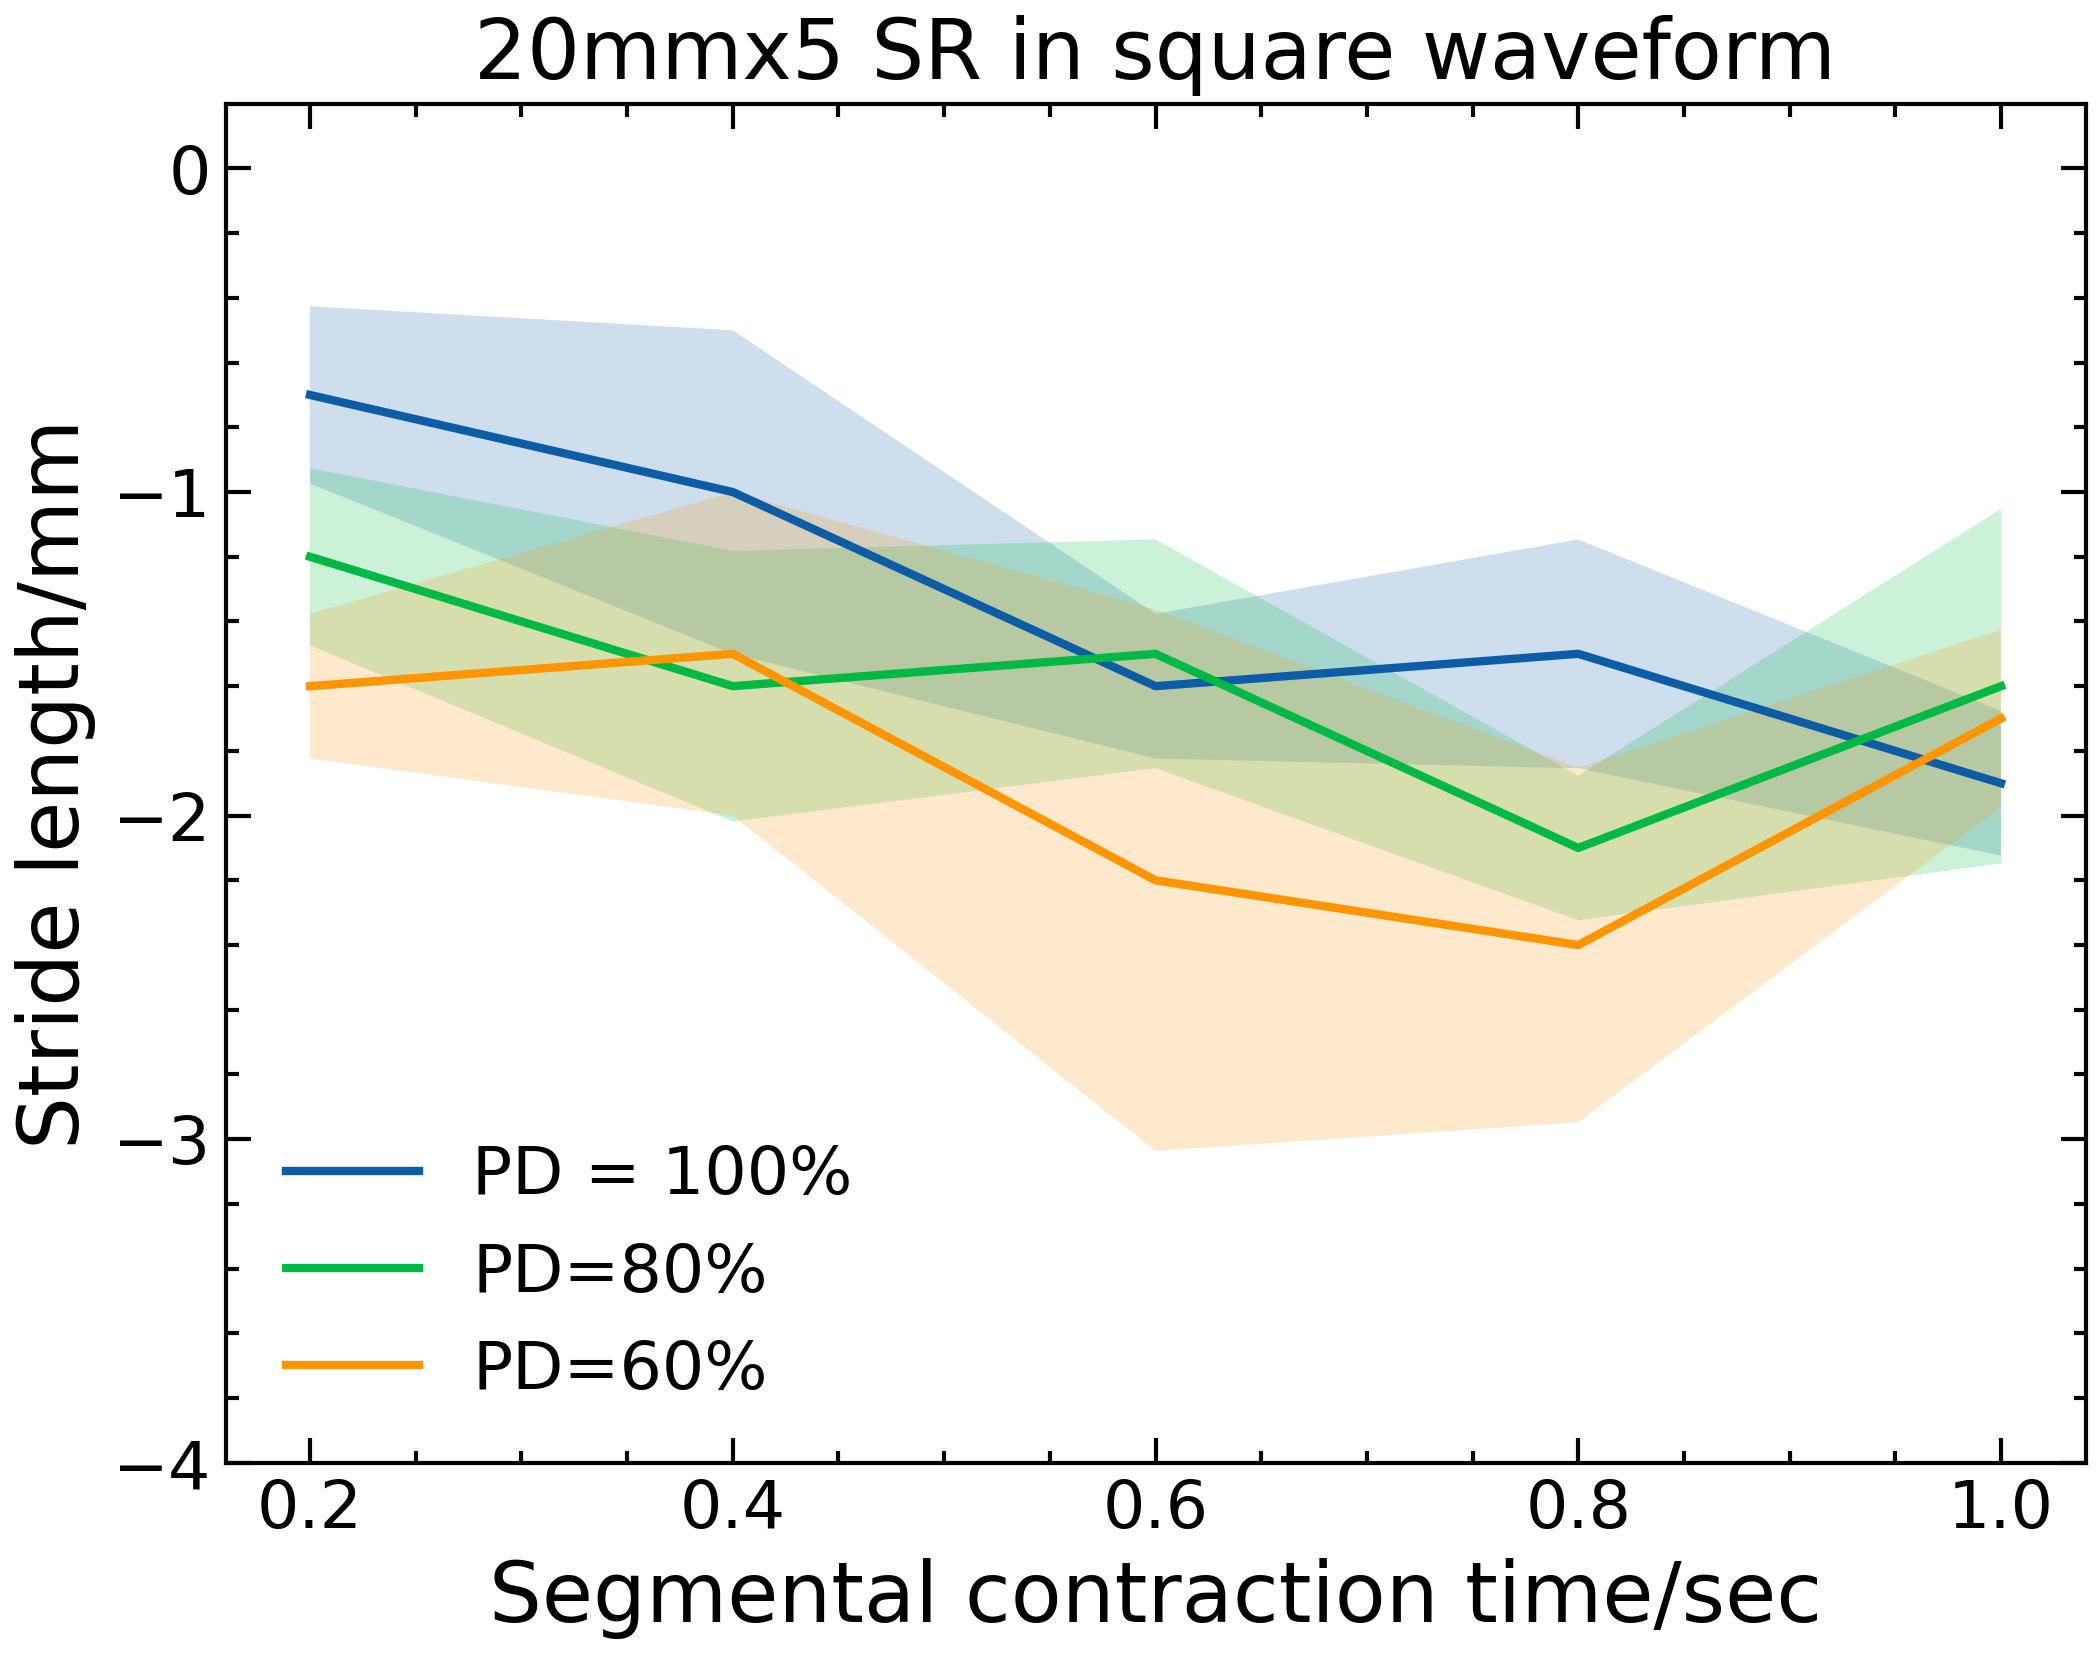

In [44]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import numpy as np

# for 20x5 SR without signal overlapping
x = np.array([0.2, 0.4, 0.6, 0.8, 1])   # stride duration
# for stride data within various waveforms
PD0 = np.array([-0.7,	-1,	-1.6,	-1.5,	-1.9]) 
PD0err = np.array([0.273861279, 	0.5,	0.223606798,	0.353553391,	0.223606798])
PD20 = np.array([-1.2,	-1.6,	-1.5,	-2.1,	-1.6])	
PD20err = np.array([0.273861279,	0.418330013,	0.353553391,	0.223606798,	0.547722558])
PD40 = np.array([-1.6,	-1.5,	-2.2,	-2.4,	-1.7])
PD40err = np.array([0.223606798,	0.5,	0.836660027,	0.547722558,	0.273861279])

# figure plotting
with plt.style.context(['science','notebook','no-latex']):
    fig = plt.figure()
    fig.add_subplot(111)
    plt.plot(x, PD0, label = 'PD = 100%')
    plt.fill_between(x, PD0-PD0err, PD0+PD0err,alpha=0.2)
    plt.plot(x, PD20, label = 'PD=80%')
    plt.fill_between(x, PD20-PD20err, PD20+PD20err,alpha=0.2)
    plt.plot(x, PD40, label = 'PD=60%')
    plt.fill_between(x, PD40-PD40err, PD40+PD40err,alpha=0.2)

    # plt.xlim(1, 5)
    plt.ylim(-4,0.2)
    ax = plt.gca()
    x_major_locator=MultipleLocator(0.2)
    ax.xaxis.set_major_locator(x_major_locator)
    y_major_locator=MultipleLocator(1)
    ax.yaxis.set_major_locator(y_major_locator)
    # the xlabel should be normalized for the phase delay results, which should be replaced with "Segmental  contraction time/s"
    plt.xlabel('Segmental contraction time/sec',fontsize = 20)
    plt.ylabel('Stride length/mm', fontsize = 20)
    plt.title('20mmx5 SR in square waveform', fontsize = 20)
    plt.legend(loc='lower left') 
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'
    plt.rcParams['savefig.dpi'] = 300 #图片像素
    plt.rcParams['figure.dpi'] = 300
    plt.savefig('SRcrawling20x5-ssquare-PD-B.png')
    plt.show()

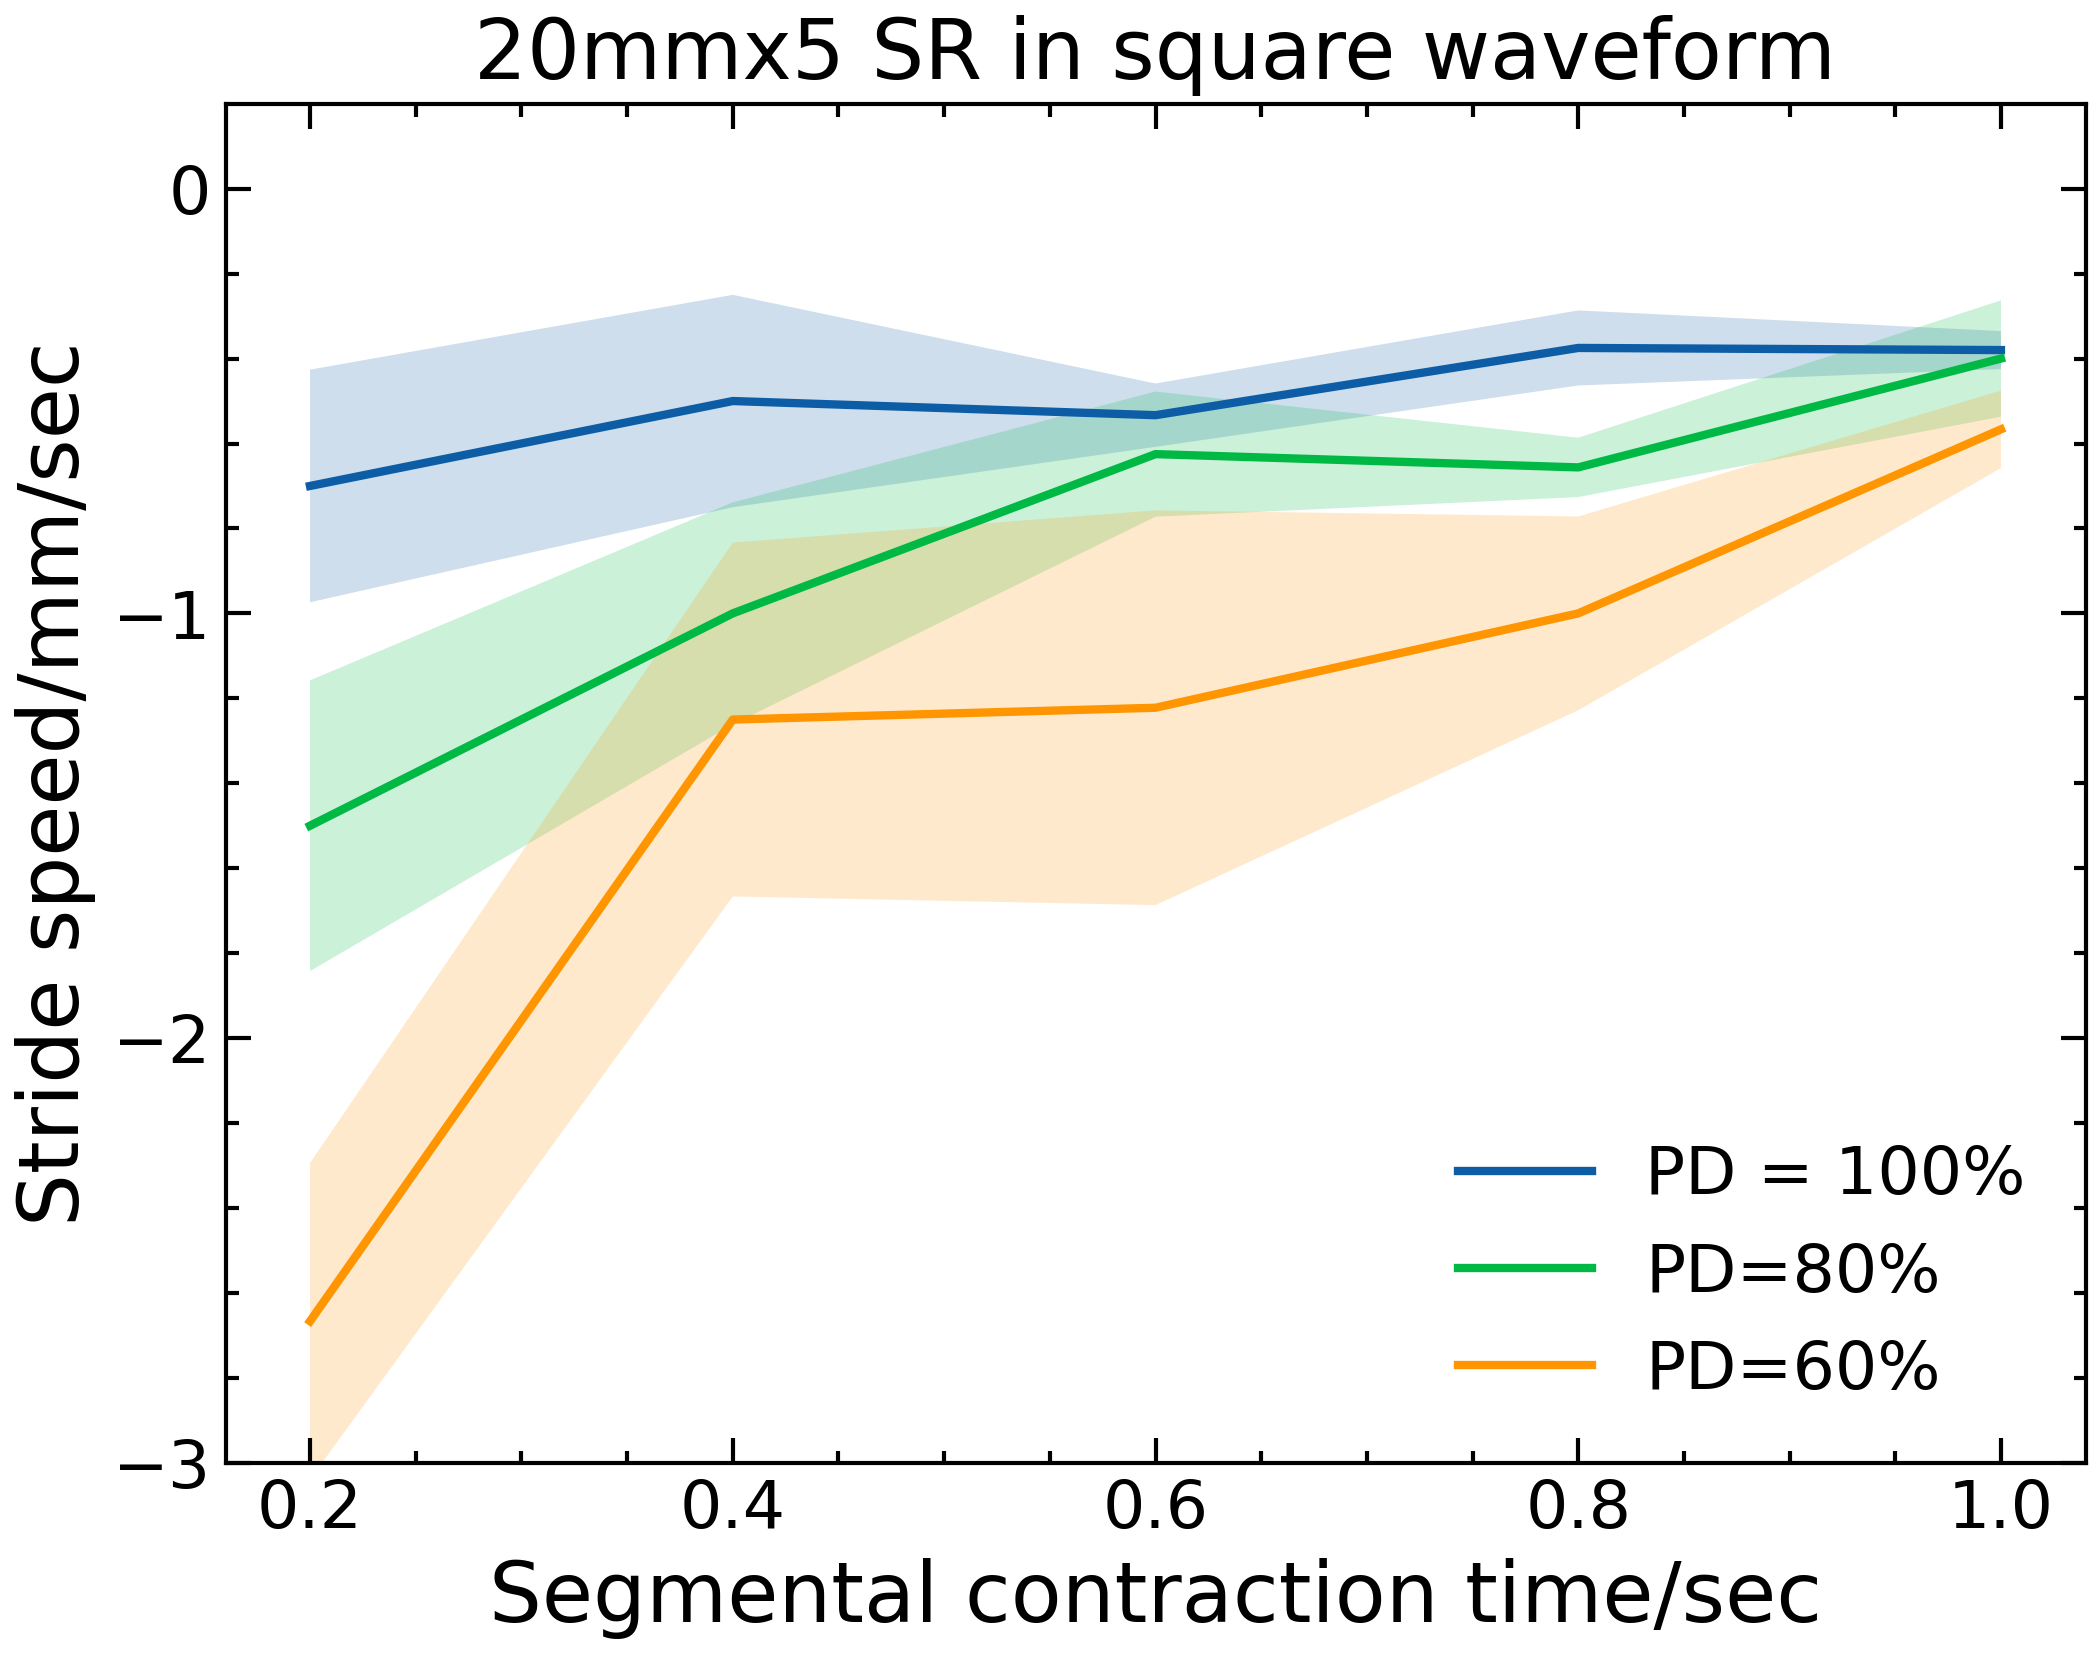

In [46]:
# plot for stride speed for backward locomotion under diverse segmental phase delay
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import numpy as np

# for 20x5 SR without signal overlapping
x = np.array([0.2, 0.4, 0.6, 0.8, 1])   # stride duration
# for stride data within various waveforms
fre1 = np.array([1, 1/2, 1/3, 1/4, 1/5])
fre2 = np.array([1/0.8, 1/1.6, 1/2.4, 1/3.2, 1/4])
fre3 = np.array([1/0.6, 1/1.2, 1/1.8, 1/2.4, 1/3])

PD0 = np.array([-0.7,	-1,	-1.6,	-1.5,	-1.9]) 
PD0err = np.array([0.273861279, 	0.5,	0.223606798,	0.353553391,	0.223606798])
PD20 = np.array([-1.2,	-1.6,	-1.5,	-2.1,	-1.6])	
PD20err = np.array([0.273861279,	0.418330013,	0.353553391,	0.223606798,	0.547722558])
PD40 = np.array([-1.6,	-1.5,	-2.2,	-2.4,	-1.7])
PD40err = np.array([0.223606798,	0.5,	0.836660027,	0.547722558,	0.273861279])

# figure plotting
with plt.style.context(['science','notebook','no-latex']):
    fig = plt.figure()
    fig.add_subplot(111)
    plt.plot(x, PD0*fre1, label = 'PD = 100%')
    plt.fill_between(x, (PD0-PD0err)*fre1, (PD0+PD0err)*fre1,alpha=0.2)
    plt.plot(x, PD20*fre2, label = 'PD=80%')
    plt.fill_between(x, (PD20-PD20err)*fre2, (PD20+PD20err)*fre2,alpha=0.2)
    plt.plot(x, PD40*fre3, label = 'PD=60%')
    plt.fill_between(x, (PD40-PD40err)*fre3, (PD40+PD40err)*fre3,alpha=0.2)

    # plt.xlim(1, 5)
    plt.ylim(-3,0.2)
    ax = plt.gca()
    x_major_locator=MultipleLocator(0.2)
    ax.xaxis.set_major_locator(x_major_locator)
    y_major_locator=MultipleLocator(1)
    ax.yaxis.set_major_locator(y_major_locator)
    # the xlabel should be normalized for the phase delay results, which should be replaced with "Segmental  contraction time/s"
    plt.xlabel('Segmental contraction time/sec',fontsize = 20)
    plt.ylabel('Stride speed/mm/sec', fontsize = 20)
    plt.title('20mmx5 SR in square waveform', fontsize = 20)
    plt.legend(loc='lower right') 
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'
    plt.rcParams['savefig.dpi'] = 300 #图片像素
    plt.rcParams['figure.dpi'] = 300
    plt.savefig('SRcrawlingSpeed20x5-ssquare-PD-B.png')
    plt.show()